# Preliminary analysis of RCA in vivo conditions

In [1]:
import os, sys
import tifffile as tif
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import colorcet as cc
import cv2
import skimage
import scipy.ndimage, scipy.stats

In [2]:
from cellpose import models, utils

## Set up directory

In [3]:
data_dir = "/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/20250422_QH_eGFP_RCA_in_vivo_IMC_decov/psf_300_-10db_i7"

# list of all files in the directory
files = os.listdir(data_dir)
files = [os.path.join(data_dir, f) for f in files if f.endswith('.tif')]
files.sort()
files

['/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/20250422_QH_eGFP_RCA_in_vivo_IMC_decov/psf_300_-10db_i7/ROI_017_deconvoluted.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/20250422_QH_eGFP_RCA_in_vivo_IMC_decov/psf_300_-10db_i7/ROI_018_deconvoluted.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/20250422_QH_eGFP_RCA_in_vivo_IMC_decov/psf_300_-10db_i7/ROI_019_deconvoluted.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/20250422_QH_eGFP_RCA_in_vivo_IMC_decov/psf_300_-10db_i7/ROI_020_deconvoluted.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/20250422_QH_eGFP_RCA_in_vivo_IMC_decov/psf_300_-10db_i7/ROI_021_deconvoluted.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/20250422_QH_eGFP_RCA_in_vivo_IMC_decov/psf_300_-10db_i7/R

In [4]:
file = files[1]
print(file)
img = tif.imread(file)
img_488 = img[10,:,:]
img_555 = img[9,:,:]

/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250426_eGFP_in_vivo_RCA/20250422_QH_eGFP_RCA_in_vivo_IMC_decov/psf_300_-10db_i7/ROI_018_deconvoluted.tif


## Exploratory analysis

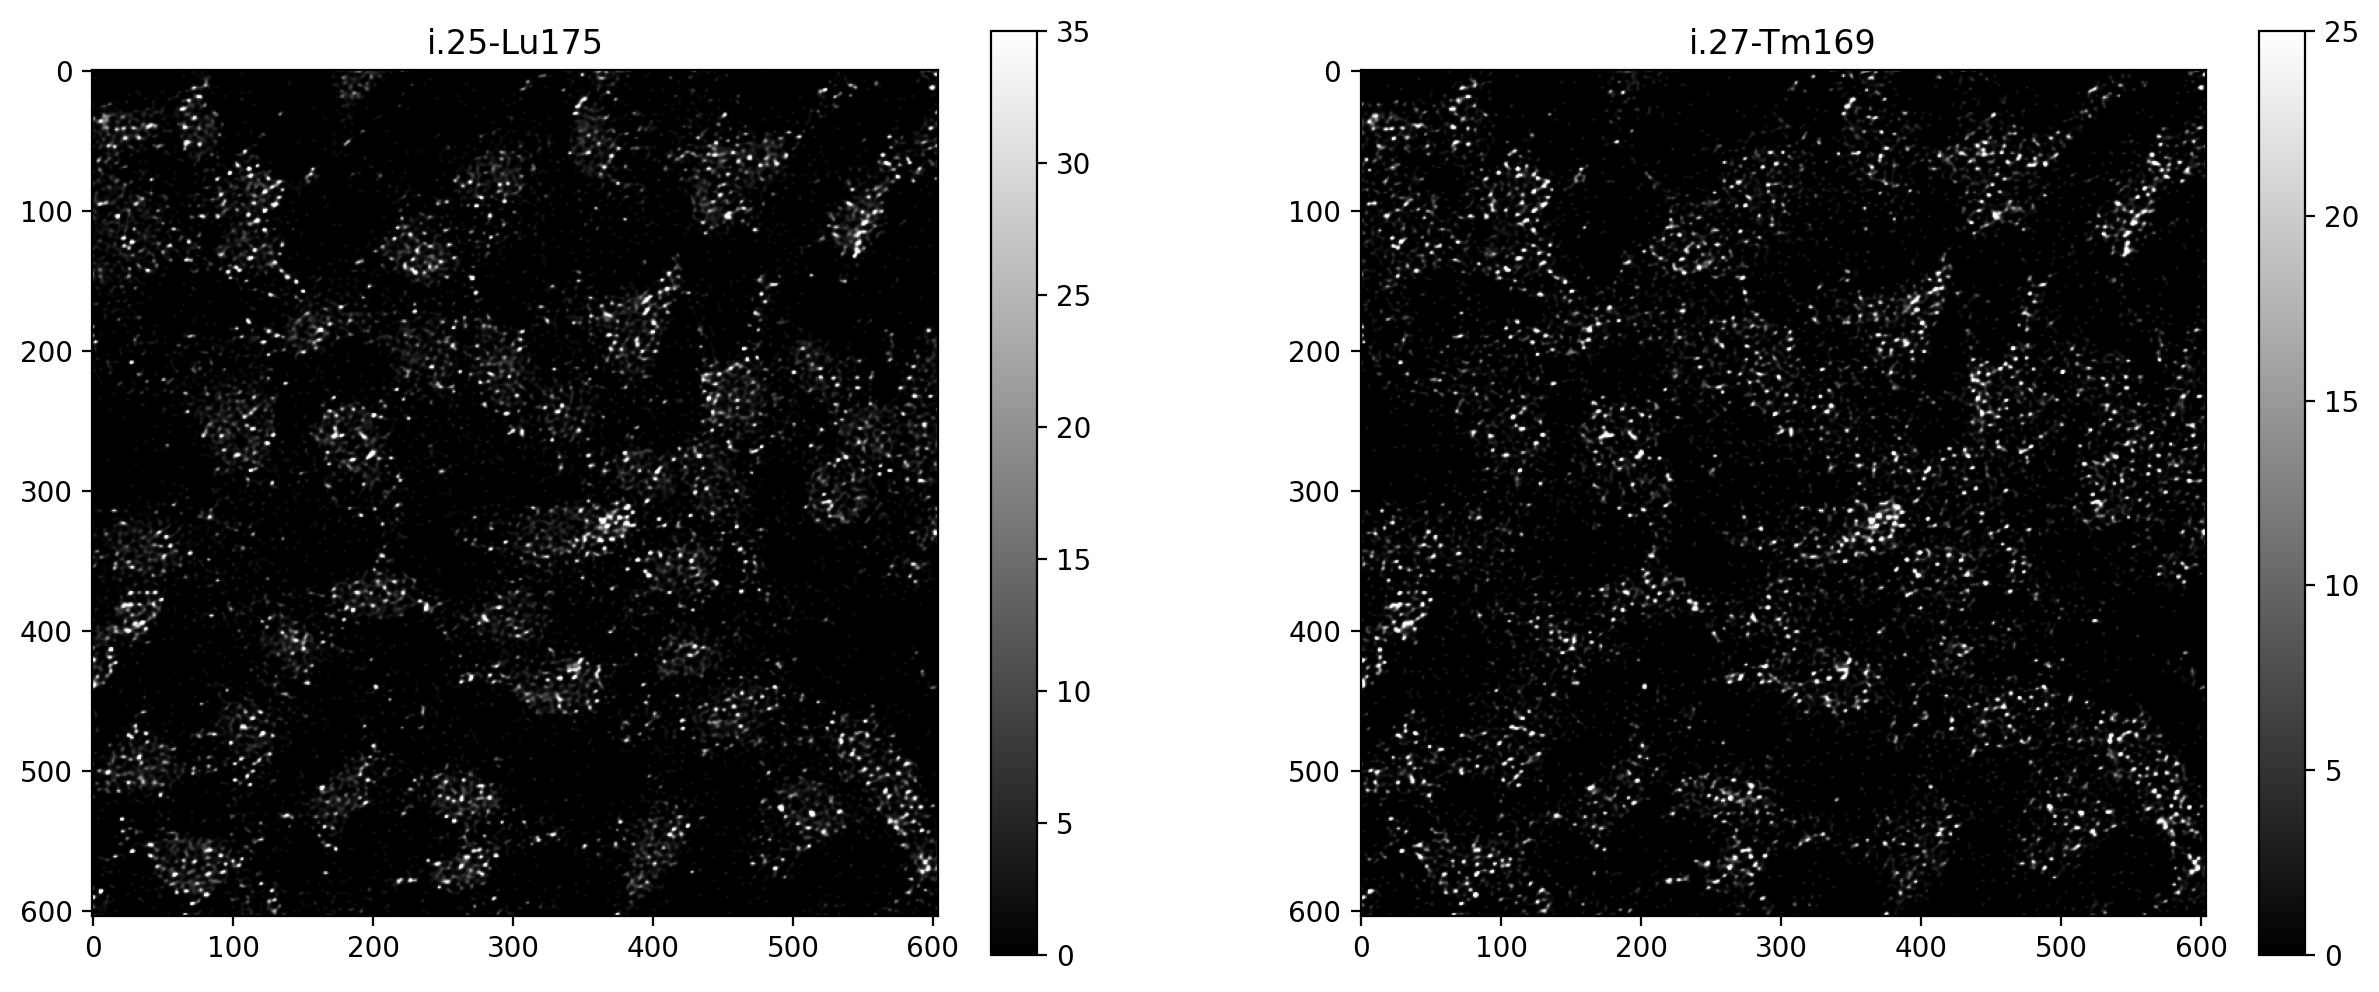

In [5]:
plt.figure(figsize=(15, 6), dpi = 200)
plt.subplot(121)
plt.imshow(img_488, cmap='gray')
plt.clim(np.percentile(img_488, 5), np.percentile(img_488, 99.9))
plt.title("i.25-Lu175")
plt.clim(0, 35)
plt.colorbar()
plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
plt.title("i.27-Tm169")
plt.clim(0, 25)
plt.colorbar()
plt.show()

Plot a line profile in the diagonal direction

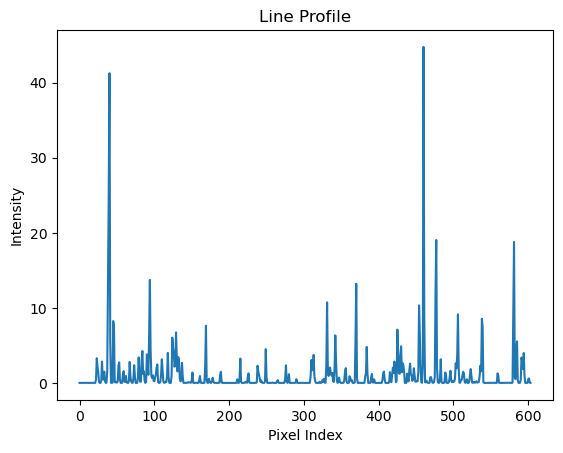

In [6]:
def plot_line_profile(img, start, end):
    # Create a mask for the line
    mask = np.zeros_like(img, dtype=np.uint8)
    cv2.line(mask, start, end, 255, 1)

    # Get the coordinates of the line
    coords = np.column_stack(np.where(mask > 0))

    # Get the pixel values along the line
    line_values = img[coords[:, 0], coords[:, 1]]

    # Plot the line profile
    plt.plot(line_values)
    plt.xlabel('Pixel Index')
    plt.ylabel('Intensity')
    plt.title('Line Profile')
    plt.show()
# Define the start and end points of the line
start = (0, 0)
end = (img_488.shape[1] - 1, img_488.shape[0] - 1)
# Plot the line profile for the first image
plot_line_profile(img_555, start, end)

## Amplicon masking and binarization

Difference of guassian and then local maxima to detect spots

In [7]:
def vis_roll_ball(img, radius):
    # slightly blur the image to remove noise
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # rolling ball algorithm to remove background
    background = skimage.restoration.rolling_ball(img, radius=radius)
    img_sub = img - background
    
    # set figure size
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.clim(np.percentile(img, 5), np.percentile(img, 99.9))
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(background, cmap='gray')
    plt.title('Background')
    plt.clim(np.percentile(background, 5), np.percentile(background, 99.9))
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(img_sub, cmap='gray')
    plt.title('Subtracted Image')
    plt.clim(np.percentile(img_sub, 5), np.percentile(img_sub, 99.9))
    plt.axis('off')

    plt.show()

    start = (0, 0)
    end = (img_sub.shape[1] - 1, img_sub.shape[0] - 1)
    plot_line_profile(img_sub, start, end)
    
def vis_gaussian(img, sigma1, sigma2):
    # difference of guassian sigma1 = 2, sigma2 = 10
    img_sig1 = skimage.filters.gaussian(img, sigma=sigma1, preserve_range=True)
    img_sig2 = skimage.filters.gaussian(img, sigma=sigma2, preserve_range=True)
    img_sub = img_sig1 - img_sig2
    
    return img_sub

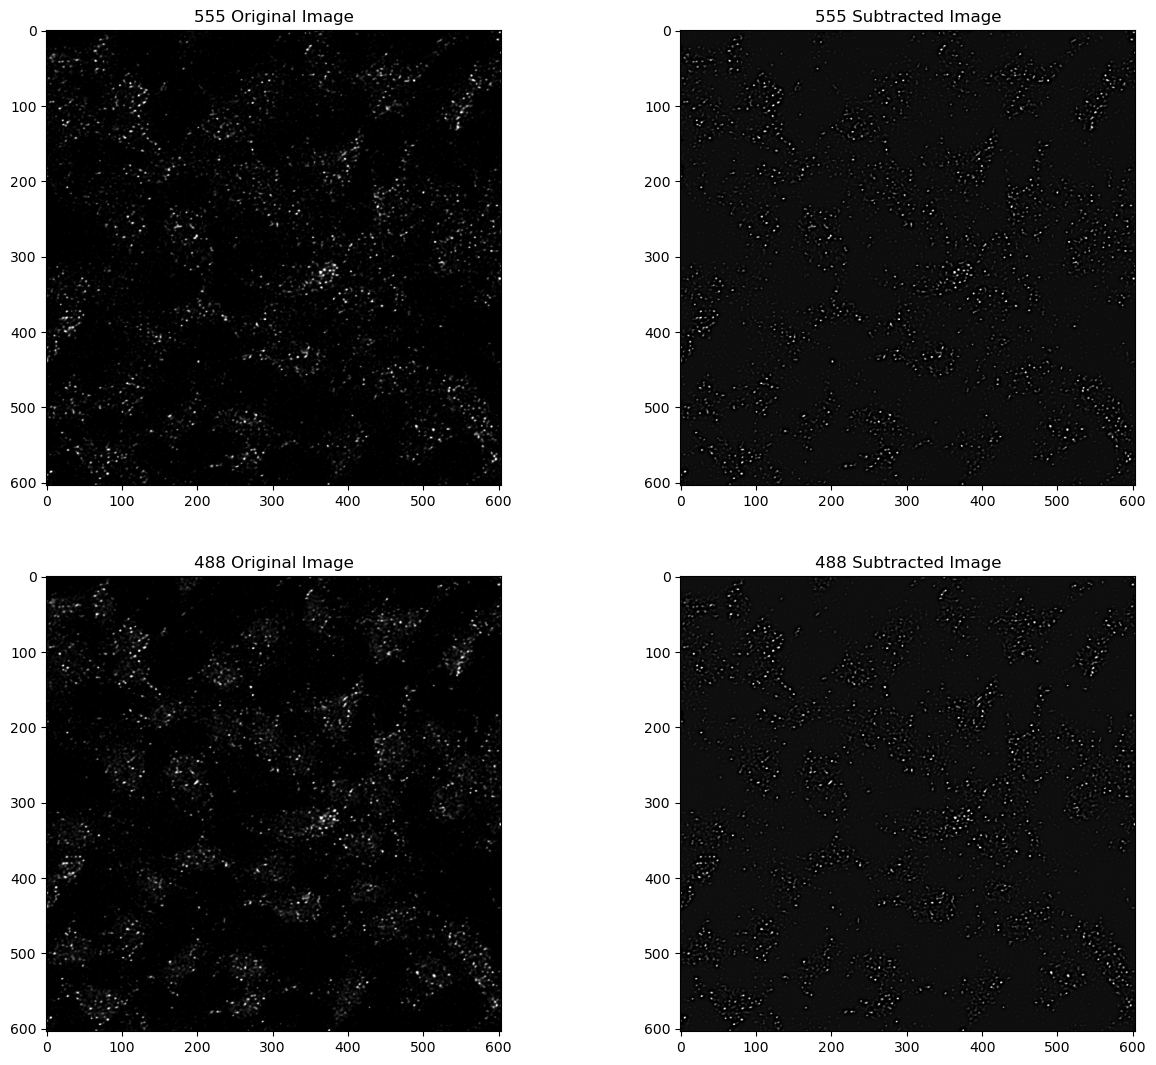

In [8]:
sigma_1 = 0
sigma_2 = 2


img_555_sub = vis_gaussian(img_555, sigma_1, sigma_2)
img_488_sub = vis_gaussian(img_488, sigma_1, sigma_2)

plt.figure(figsize=(15, 13), dpi=100)
plt.subplot(221)
plt.imshow(img_555, cmap='gray')
plt.title('555 Original Image')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
# plt.axis('off')
plt.subplot(222)
plt.imshow(img_555_sub, cmap='gray')
plt.title('555 Subtracted Image')
plt.clim(np.percentile(img_555_sub, 5), np.percentile(img_555_sub, 99.9))
# plt.axis('off')
plt.subplot(223)
plt.imshow(img_488, cmap='gray')
plt.title('488 Original Image')
plt.clim(np.percentile(img_488, 5), np.percentile(img_488, 99.9))
# plt.axis('off')
plt.subplot(224)
plt.imshow(img_488_sub, cmap='gray')
plt.title('488 Subtracted Image')
plt.clim(np.percentile(img_488_sub, 5), np.percentile(img_488_sub, 99.9))
# plt.axis('off')
plt.show()

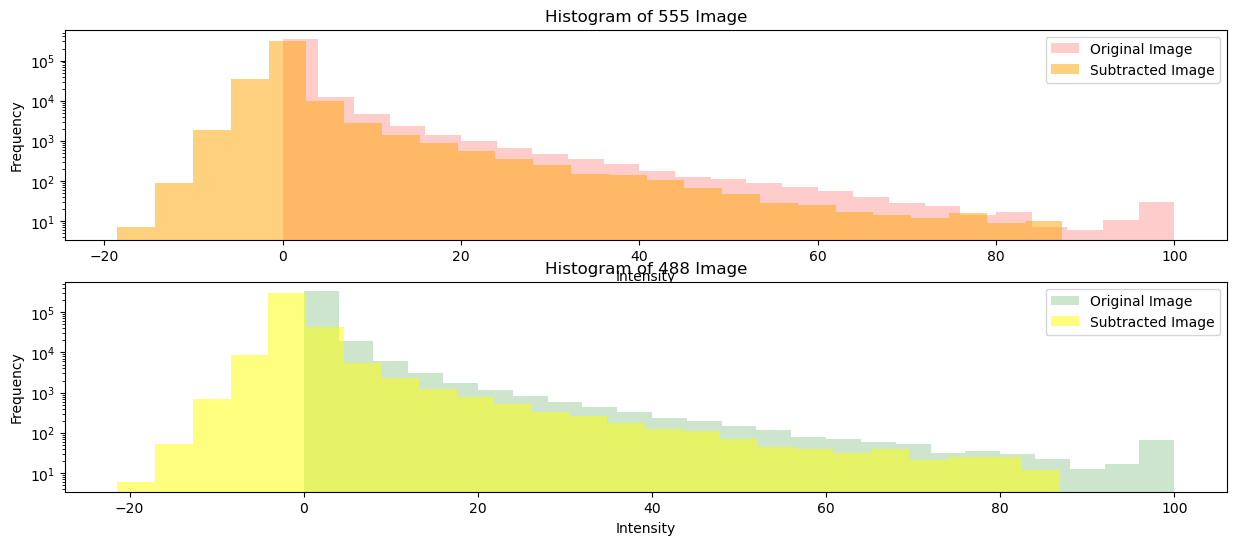

In [9]:

# plot the histogram before and after background subtraction
plt.figure(figsize=(15, 6), dpi=100)
plt.subplot(211)
# plt.hist(img_555_background.flatten(), bins=5, color='gray', alpha=0.5, label='Background Image')
plt.hist(img_555.flatten(), bins=25, color='red', alpha=0.2, label='Original Image')
plt.hist(img_555_sub.flatten(), bins=25, color='orange', alpha=0.5, label='Subtracted Image')
plt.title('Histogram of 555 Image')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
# set y into log
plt.yscale('log')
plt.legend()
plt.subplot(212)
# plt.hist(img_488_background.flatten(), bins=5, color='gray', alpha=0.5, label='Background Image')
plt.hist(img_488.flatten(), bins=25, color='green', alpha=0.2, label='Original Image')
plt.hist(img_488_sub.flatten(), bins=25, color='yellow', alpha=0.5, label='Subtracted Image')
plt.title('Histogram of 488 Image')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()
plt.show()

Local max (circular kernel)

In [10]:
def maximum_filter(img, radius):
    # set a circular kernel
    kernel = cv2.circle(np.zeros((radius*2+1, radius*2+1), dtype=np.uint8), (radius, radius), radius, 1, -1)
    
    # apply the maximum filter using the circular kernel, consider a reflective border
    img_max = cv2.dilate(img, kernel, iterations=1)
    return img_max

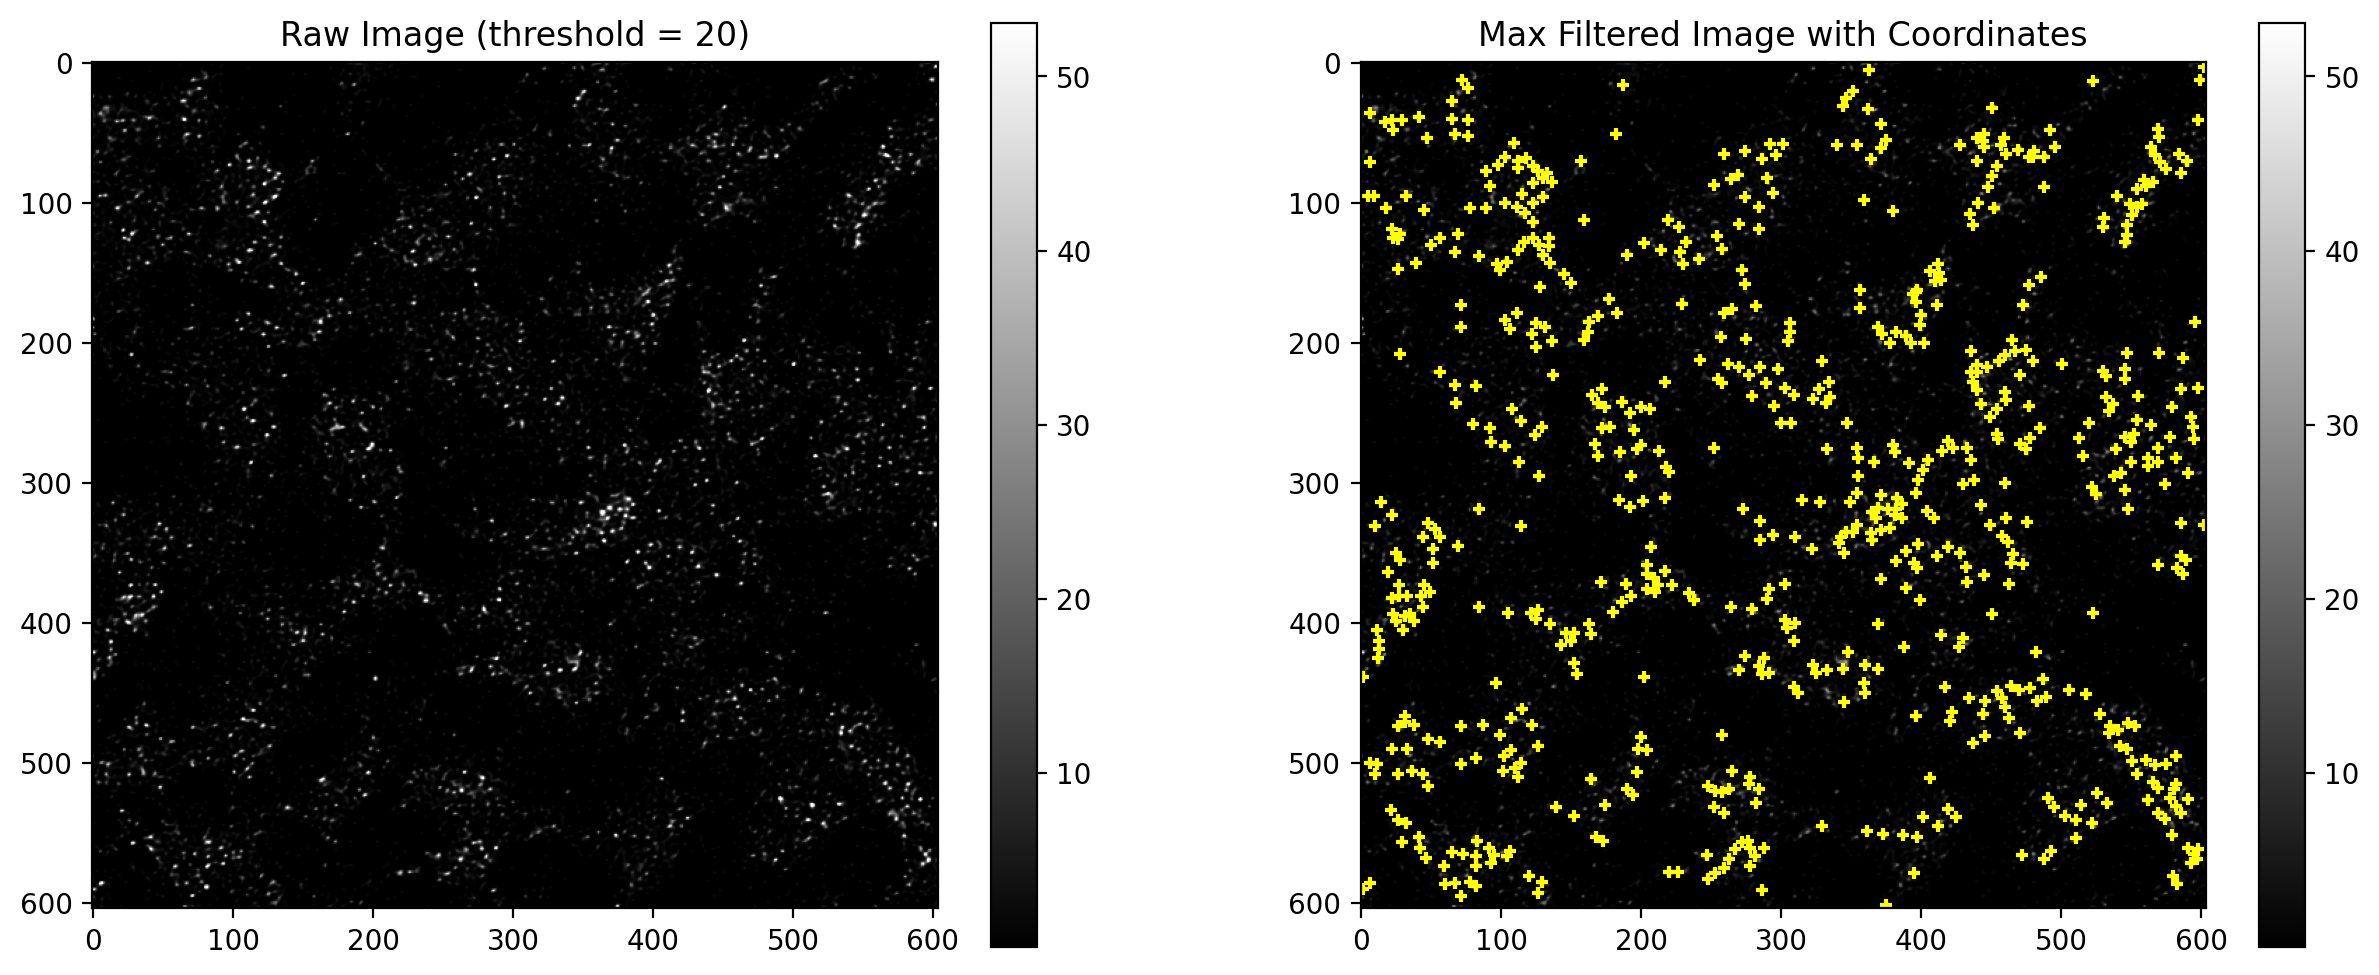

In [11]:
# img_555_max = scipy.ndimage.maximum_filter(img_555_sub, size=5)
# img_555_max = maximum_filter(img_555_sub, radius=0)
img_555_max = maximum_filter(img_555, radius=0)
thres = 20
coordinates = skimage.feature.peak_local_max(img_555_sub, min_distance=1, threshold_abs=thres)

plt.figure(figsize=(15, 6), dpi=200)
plt.subplot(121)
plt.imshow(img_555_max, cmap='gray')
plt.title('Raw Image (threshold = {})'.format(thres))
plt.clim(np.percentile(img_555_max, 5), np.percentile(img_555_max, 99.9))
# plt.xlim(500, 1000)
# plt.ylim(2000, 1500)
plt.colorbar()

plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.title('Max Filtered Image with Coordinates')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))

plt.colorbar()
# overlay the coordinates on the image
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=20, marker = '+')
    
# plt.xlim(500, 1000)
# plt.ylim(2000, 1500)
    
plt.show()

Coarse peak intensity correlation

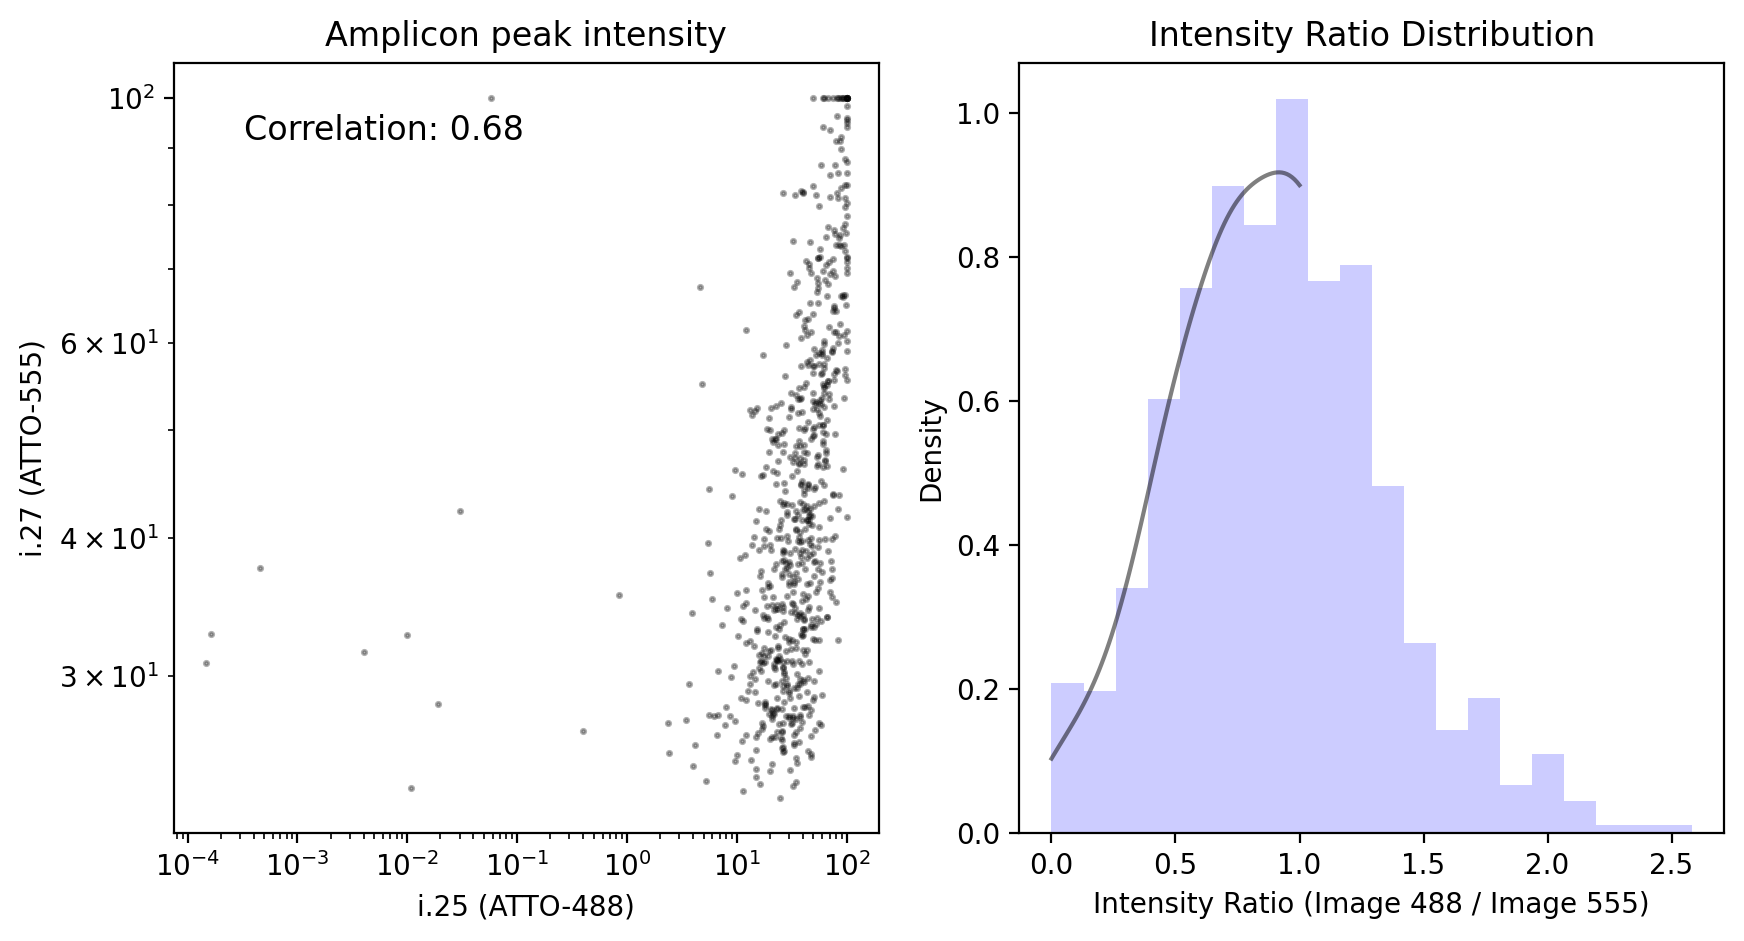

In [12]:
# plot a scatter plot correlating the intensity of img_488 and img_555 in the same coordinates
def plot_scatter(img1, img2, coordinates):
    # Get the pixel values at the coordinates
    values1 = img1[coordinates[:, 0], coordinates[:, 1]]
    values2 = img2[coordinates[:, 0], coordinates[:, 1]]

    # remove data pair if any of them is higher than 60000
    mask = (values1 < 60000) & (values2 < 60000)
    values1 = values1[mask]
    values2 = values2[mask]
    
    # ratio
    ratio = values1/values2
    
    # Plot the scatter plot
    plt.figure(figsize=(10,5), dpi = 200)
    plt.subplot(121)
    plt.scatter(values1, values2, c='black', s=10, alpha=0.3, marker='.')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('i.25 (ATTO-488)')
    plt.ylabel('i.27 (ATTO-555)')
    plt.title('Amplicon peak intensity')
    # compute the correlation coefficient
    correlation = np.corrcoef(values1, values2)[0, 1]
    plt.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12)
    
    plt.subplot(122)
    # plot a smoothened histogram of the intensity ratio
    plt.hist(ratio, bins=20, color='blue', alpha=0.2, density=True)
    kde = scipy.stats.gaussian_kde(ratio)
    x = np.linspace(0, 1, 100)
    plt.plot(x, kde(x), color='black', alpha=0.5)
    plt.xlabel('Intensity Ratio (Image 488 / Image 555)')
    plt.ylabel('Density')
    plt.title('Intensity Ratio Distribution')
    
    plt.show()
    
    
    
# Convert coordinates to a numpy array
coordinates = np.array(coordinates)
# Plot the scatter plot
plot_scatter(img_488, img_555, coordinates)

whole-amplicon intensity correlation

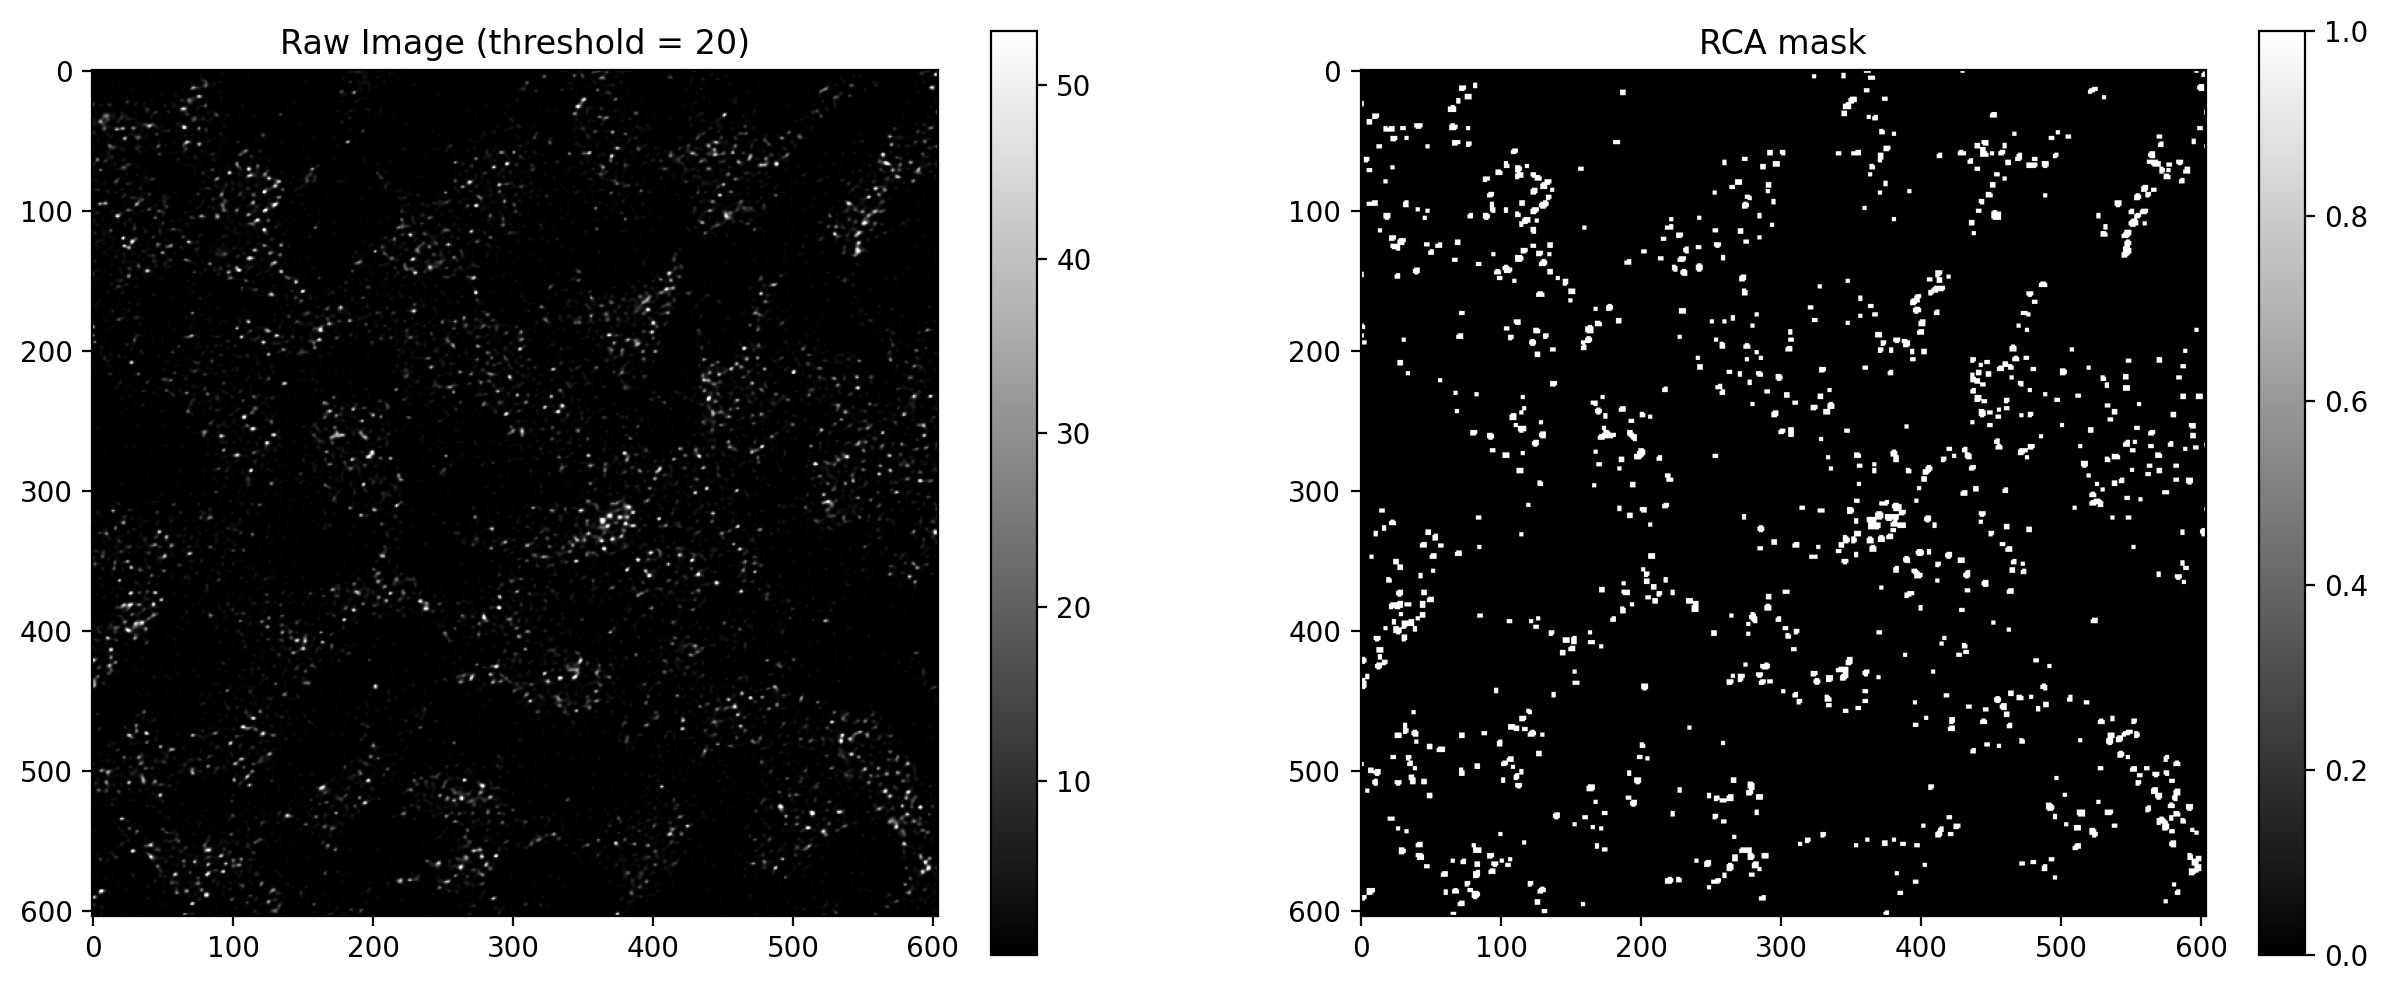

In [13]:
img_mask = img_555_max > thres
# dilate the mask
kernel = np.ones((3, 3), np.uint8)
img_mask = cv2.dilate(img_mask.astype(np.uint8), kernel, iterations=1)

plt.figure(figsize=(15, 6), dpi=200)
plt.subplot(121)
plt.imshow(img_555_max, cmap='gray')
plt.title('Raw Image (threshold = {})'.format(thres))
plt.clim(np.percentile(img_555_max, 5), np.percentile(img_555_max, 99.9))
# plt.xlim(500, 1000)
# plt.ylim(2000, 1500)
plt.colorbar()

plt.subplot(122)
plt.imshow(img_mask, cmap='gray')
plt.title('RCA mask')
plt.clim(0, 1)
# plt.xlim(1000, 1250)
# plt.ylim(1000, 1250)
plt.colorbar()

plt.show()

In [14]:
# turn the mask into a label image
img_mask = skimage.measure.label(img_mask)
img_488_df = skimage.measure.regionprops_table(img_mask, img_488, properties=['label', 'centroid', 'area', 'mean_intensity'])
img_555_df = skimage.measure.regionprops_table(img_mask, img_555, properties=['label', 'centroid', 'area', 'mean_intensity'])

In [15]:
img_488_df = pd.DataFrame(img_488_df)
img_555_df = pd.DataFrame(img_555_df)

# add one column to store area*mean_intensity as total_intensity
img_488_df['total_intensity'] = img_488_df['area'] * img_488_df['mean_intensity']
img_555_df['total_intensity'] = img_555_df['area'] * img_555_df['mean_intensity']

# merge the two dataframes on label, keep area, centroid-0, centroid-1 only from img_488_df, the rest add the suffixes
amp_df = pd.merge(img_488_df, img_555_df, on='label', suffixes=('_488', '_555'))

amp_df.rename(columns={'area_488': 'area', 'centroid-0_488': 'centroid-0', 'centroid-1_488': 'centroid-1'}, inplace=True)
amp_df.drop(columns=['area_555', 'centroid-0_555', 'centroid-1_555'], inplace=True)

# change the column name "centroid-0" to "y"
amp_df.rename(columns={'centroid-0': 'y'}, inplace=True)
# change the column name "centroid-1" to "x"
amp_df.rename(columns={'centroid-1': 'x'}, inplace=True)

amp_df

label           y           x  area  mean_intensity_488  \
0        1    0.500000  361.000000  10.0           19.013234   
1        2    0.500000  429.000000   6.0           11.579073   
2        3    0.500000  596.000000   6.0            9.354066   
3        4    2.600000  601.600000  15.0           18.701240   
4        5    3.500000  344.000000  12.0            0.636115   
..     ...         ...         ...   ...                 ...   
839    840  594.578947   71.105263  19.0           22.060162   
840    841  595.000000  158.000000   9.0            1.951894   
841    842  600.000000  130.500000  12.0           14.490633   
842    843  601.600000  374.600000  15.0           23.487944   
843    844  602.000000   65.500000  12.0           15.341989   

     total_intensity_488  mean_intensity_555  total_intensity_555  
0             190.132341           15.271711           152.717108  
1              69.474439            8.294723            49.768340  
2              56.124394           10.316781            61.900685  
3             280.518596           20.193295           302.899428  
4               7.633386            7.411590            88.939078  
..                   ...                 ...                  ...  
839           419.143082           14.284068           271.397292  
840            17.567050            6.962635            62.663711  
841           173.887600           14.587308           175.047691  
842           352.319160           16.393258           245.898867  
843           184.103864           12.885712           154.628550  

[844 rows x 8 columns]

In [16]:
# # save dataframe to csv
# output_dir = os.path.join(data_dir, 'dataframe')
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# amp_df.to_csv(os.path.join(output_dir, 'RCA_df_'+os.path.basename(file)[:-4]+'.csv'), index=False)

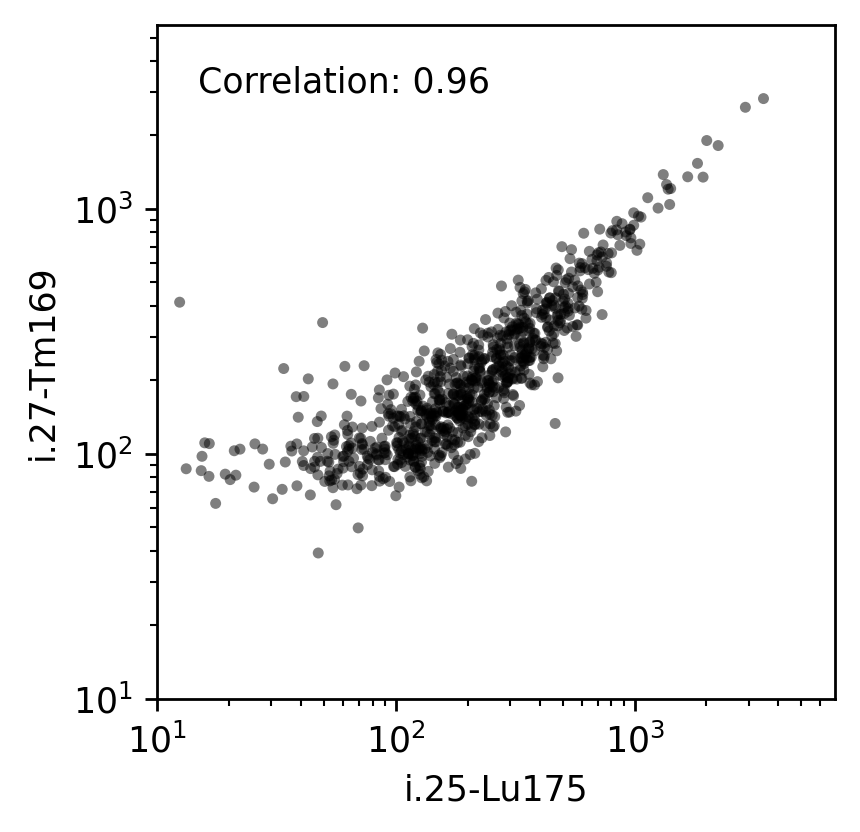

Mean ratio:  1.0661453084023973
Median ratio:  1.0667223145376372


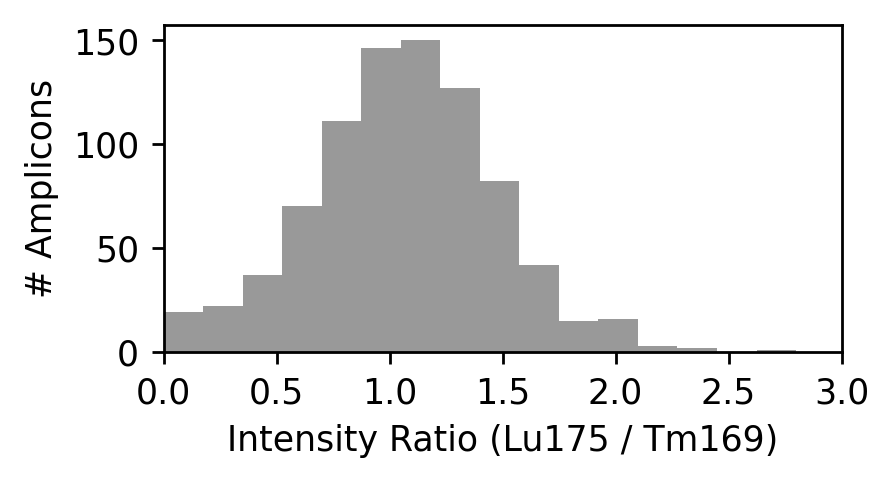

In [17]:
# plot scatter plot of total intensity
plt.figure(figsize=(3.5,3.5), dpi = 250)
plt.scatter(amp_df['total_intensity_488'], amp_df['total_intensity_555'], c='black', s=40, alpha=0.5, marker='.', edgecolors='none')
plt.xlabel('i.25-Lu175')
plt.ylabel('i.27-Tm169')
# plt.title('Amplicon total intensity')
# compute the correlation coefficient
correlation = np.corrcoef(amp_df['total_intensity_488'], amp_df['total_intensity_555'])[0, 1]
plt.text(0.06, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=10)
plt.xlim(10, 2*np.max(amp_df['total_intensity_488']))
plt.ylim(10, 2*np.max(amp_df['total_intensity_555']))
# turn on log scale
plt.xscale('log')
plt.yscale('log')
plt.show()

# print the mean and median of the intensity ratio
mean_ratio = np.mean(amp_df['total_intensity_488']/amp_df['total_intensity_555'])
median_ratio = np.median(amp_df['total_intensity_488']/amp_df['total_intensity_555'])
print('Mean ratio: ', mean_ratio)
print('Median ratio: ', median_ratio)
plt.figure(figsize=(3.5,1.7), dpi = 250)
# plot a smoothened histogram of the intensity ratio
plt.hist(amp_df['total_intensity_488']/amp_df['total_intensity_555'], bins=20,  color='gray', alpha=0.8, density=False)
kde = scipy.stats.gaussian_kde(amp_df['total_intensity_488']/amp_df['total_intensity_555'])
# x = np.linspace(0, 1, 100)
# plt.plot(x, kde(x), color='black', alpha=0.5)
plt.xlim(0,3)
plt.xlabel('Intensity Ratio (Lu175 / Tm169)')
plt.ylabel('# Amplicons')
# plt.title('Intensity Ratio Distribution')
plt.show()

In [18]:
voxel_size = 0.33

Mean diameter:  1502.9864512129493
Median diameter:  1442.1639283815446


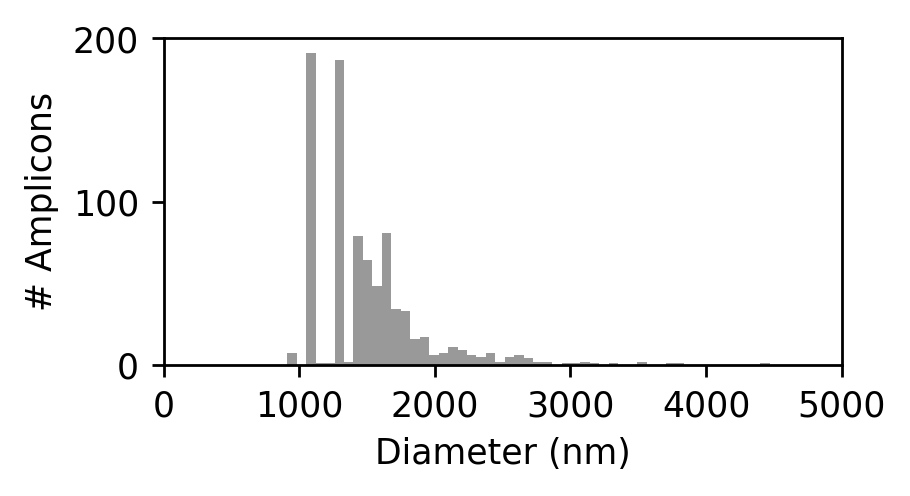

In [19]:
plt.figure(figsize=(3.5, 1.7), dpi=250)
# plot a histogram of the area for each amplicon
# plt.subplot(122)
diameter = np.sqrt(amp_df['area']/np.pi) * 2 * voxel_size * 1000
print('Mean diameter: ', np.mean(diameter))
print('Median diameter: ', np.median(diameter))
plt.hist(diameter, bins='auto', color='gray', alpha=0.8, label='Amplicon diameter', density=False)
plt.xlim(0, 5000)
# plt.ylim(0, 200)
# plt.title('Amplicon Diameter')

plt.xlabel('Diameter (nm)')
plt.ylabel('# Amplicons')

# set subplot distance
# plt.tight_layout(pad=3.0)
plt.show()


### Compute SNR

Define SNR as mean intensity / std(background)

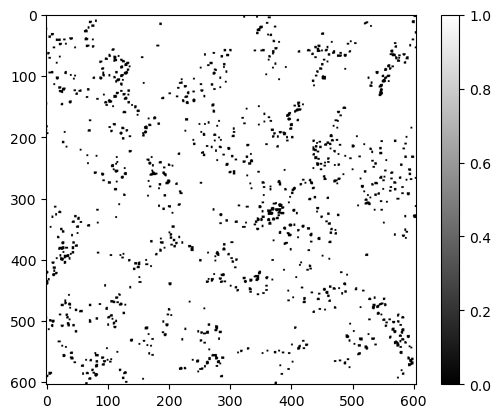

In [20]:
# find the background by inverting the mask
img_mask_bin = img_mask.copy()
img_mask_bin[img_mask_bin > 0] = 1
img_mask_inv = np.invert(img_mask_bin)
# normalize the mask to 0-1
img_mask_inv = (img_mask_inv-img_mask_inv.min())/np.abs(img_mask_inv.max()-img_mask_inv.min())
plt.imshow(img_mask_inv, cmap='gray')
plt.clim(0, 1)
plt.colorbar()

In [21]:
# compute the standard deviation of the background
background_std_555 = np.std(img_555[img_mask_inv > 0])
background_mean_555 = np.mean(img_555[img_mask_inv > 0])
background_std_488 = np.std(img_488[img_mask_inv > 0])
background_mean_488 = np.mean(img_488[img_mask_inv > 0])
print(f"Background mean: {background_mean_555:.2f}, std: {background_std_555:.2f}")
print(f"Background mean: {background_mean_488:.2f}, std: {background_std_488:.2f}")
# add a column to the amp_df for the SNR
amp_df['SNR_555'] = 0
amp_df['SNR_488'] = 0

# compute the SNR for each amplicon
for label in amp_df['label'].tolist():
    # compute the mean intensity of the amplicon
    peak_intensity_555 = img_555[amp_df.loc[amp_df['label'] == label]['y'].astype(int), amp_df.loc[amp_df['label'] == label]['x'].astype(int)]
    peak_intensity_488 = img_488[amp_df.loc[amp_df['label'] == label]['y'].astype(int), amp_df.loc[amp_df['label'] == label]['x'].astype(int)]
    # compute the SNR
    snr_555 = (np.mean(peak_intensity_555) - background_mean_555) / background_std_555
    snr_488 = (np.mean(peak_intensity_488) - background_mean_488) / background_std_488
    # add the SNR to the amp_df
    amp_df.loc[amp_df['label'] == label, 'SNR_555'] = snr_555
    amp_df.loc[amp_df['label'] == label, 'SNR_488'] = snr_488

Background mean: 0.61, std: 1.56
Background mean: 0.95, std: 2.32


/tmp/ipykernel_447629/3779260486.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.368020992225784' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  amp_df.loc[amp_df['label'] == label, 'SNR_555'] = snr_555
/tmp/ipykernel_447629/3779260486.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.761166711497587' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  amp_df.loc[amp_df['label'] == label, 'SNR_488'] = snr_488


In [22]:
amp_df

label           y           x  area  mean_intensity_488  \
0        1    0.500000  361.000000  10.0           19.013234   
1        2    0.500000  429.000000   6.0           11.579073   
2        3    0.500000  596.000000   6.0            9.354066   
3        4    2.600000  601.600000  15.0           18.701240   
4        5    3.500000  344.000000  12.0            0.636115   
..     ...         ...         ...   ...                 ...   
839    840  594.578947   71.105263  19.0           22.060162   
840    841  595.000000  158.000000   9.0            1.951894   
841    842  600.000000  130.500000  12.0           14.490633   
842    843  601.600000  374.600000  15.0           23.487944   
843    844  602.000000   65.500000  12.0           15.341989   

     total_intensity_488  mean_intensity_555  total_intensity_555    SNR_555  \
0             190.132341           15.271711           152.717108  19.368021   
1              69.474439            8.294723            49.768340  13.303316   
2              56.124394           10.316781            61.900685  14.063103   
3             280.518596           20.193295           302.899428  10.483679   
4               7.633386            7.411590            88.939078  13.328853   
..                   ...                 ...                  ...        ...   
839           419.143082           14.284068           271.397292  26.126043   
840            17.567050            6.962635            62.663711  13.287271   
841           173.887600           14.587308           175.047691  15.047333   
842           352.319160           16.393258           245.898867   6.798095   
843           184.103864           12.885712           154.628550  13.127091   

       SNR_488  
0    16.761167  
1     9.728138  
2     6.748750  
3     9.513905  
4    -0.098010  
..         ...  
839  29.080178  
840   0.469336  
841  11.032043  
842   1.672803  
843   7.833597  

[844 rows x 10 columns]

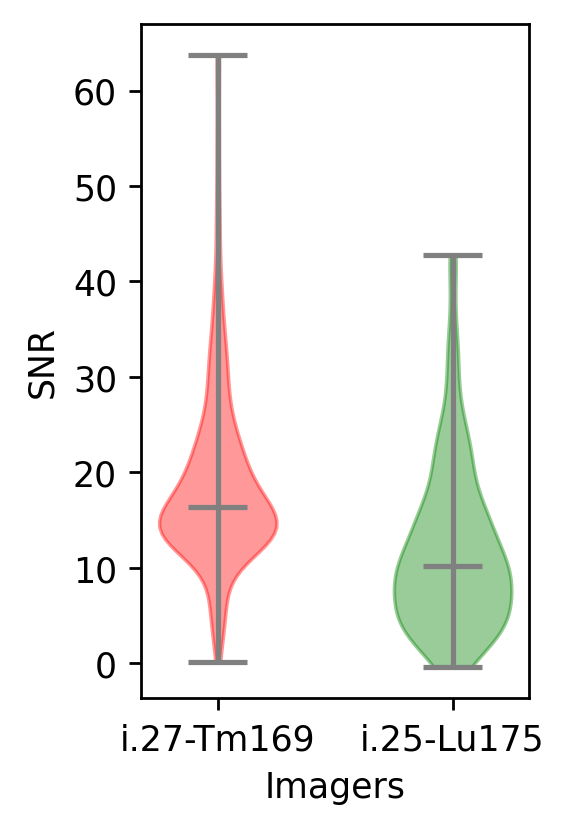

In [23]:
fig, ax = plt.subplots(1,1, figsize=(2., 3.5), dpi=250)
plots = ax.violinplot([amp_df['SNR_555'], amp_df['SNR_488']], showmeans=False, showmedians=True, showextrema=True)
colors = ['red', 'green']
for pc, color in zip(plots['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor(color)
    pc.set_alpha(0.4)
    
# set the color of lines
lw = 1.5
plots['cmedians'].set_edgecolor('gray')
plots['cmedians'].set_linewidth(lw)
plots['cmaxes'].set_edgecolor('gray')
plots['cmaxes'].set_linewidth(lw)
plots['cmins'].set_edgecolor('gray')
plots['cmins'].set_linewidth(lw)
plots['cbars'].set_edgecolor('gray')
plots['cbars'].set_linewidth(lw)

# set x tickes
plt.xticks([1, 2], ['i.27-Tm169', 'i.25-Lu175'])
plt.xlabel('Imagers')
plt.ylabel('SNR')
plt.show()

In [24]:
# save the dataframes to csv
df_dir = os.path.join(data_dir, "dataframes")
if not os.path.exists(df_dir):
    os.makedirs(df_dir)
amp_df.to_csv(os.path.join(df_dir, os.path.basename(file).replace('.tif', '_amp_df.csv')), index=False)

## Nuclear segmentation and visualization

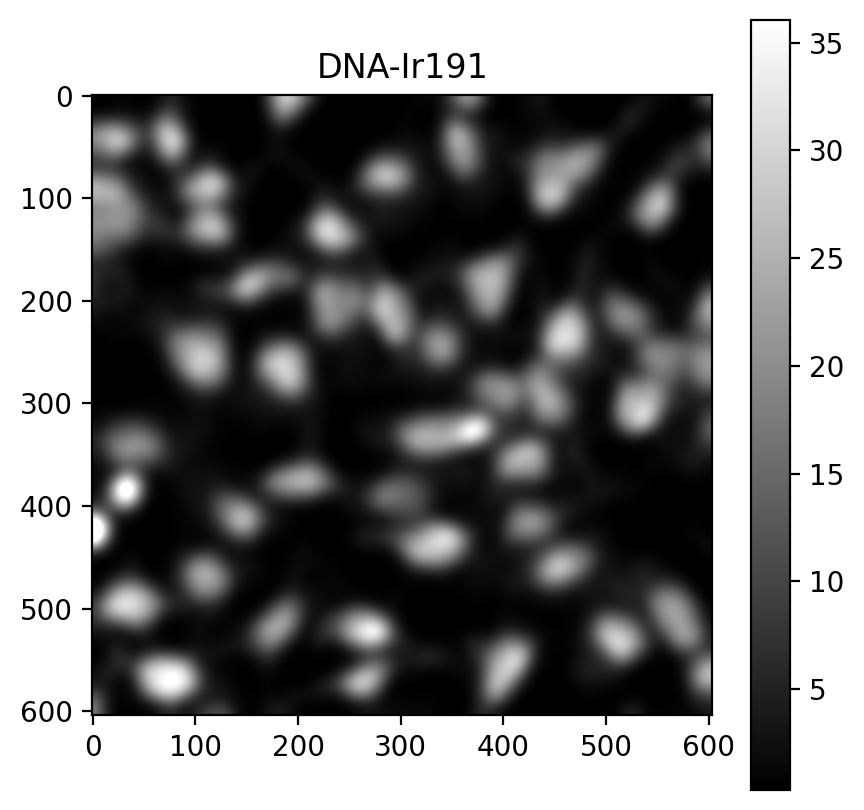

In [26]:
img_nuc = img[11,:,:]

# blur the img_nuc
img_nuc = cv2.GaussianBlur(img_nuc, (0, 0), 8)

plt.figure(figsize=(5,5), dpi=200)
plt.imshow(img_nuc, cmap='gray')
plt.clim(np.percentile(img_nuc, 5), np.percentile(img_nuc, 99.9))
plt.title("DNA-Ir191")
plt.colorbar()
plt.show()


In [27]:
model_nuc = models.Cellpose(model_type="nuclei")

In [28]:
channels = [[0, 0]]

nmasks, nflows, nstyles, ndiams = model_nuc.eval(img_nuc, diameter=None, channels = channels)

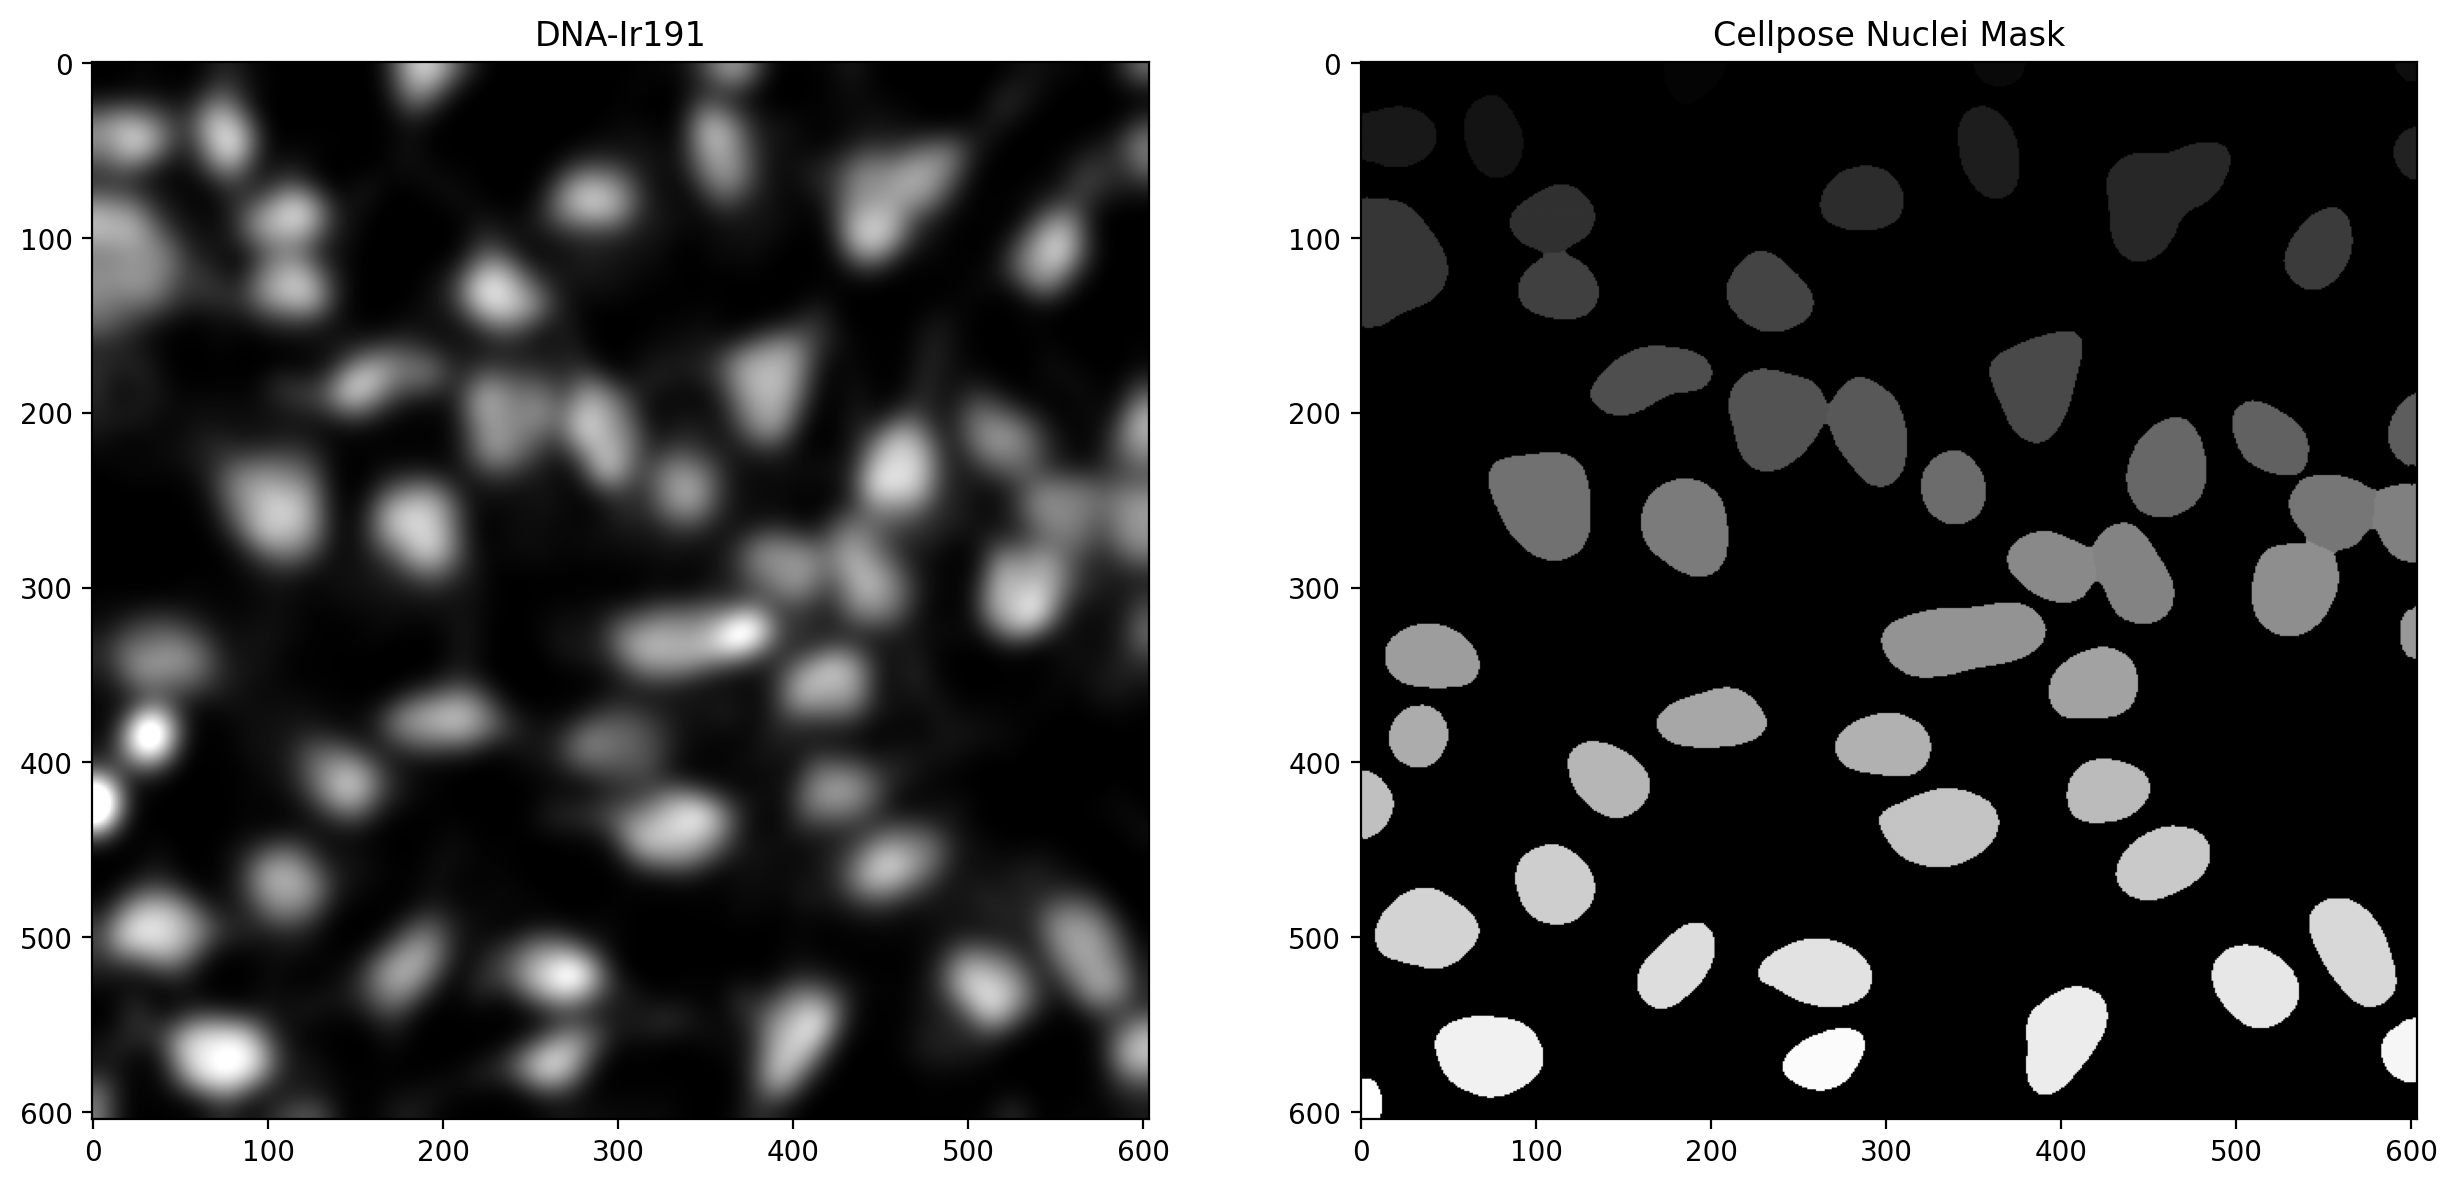

In [29]:
# show the masks
plt.figure(figsize=(15, 15), dpi = 200)

plt.subplot(121)
plt.imshow(img_nuc, cmap='gray')
plt.clim(np.percentile(img_nuc, 5), np.percentile(img_nuc, 99.9))
plt.title("DNA-Ir191")

plt.subplot(122)
plt.imshow(nmasks, cmap='gray')
plt.title("Cellpose Nuclei Mask")
plt.show()

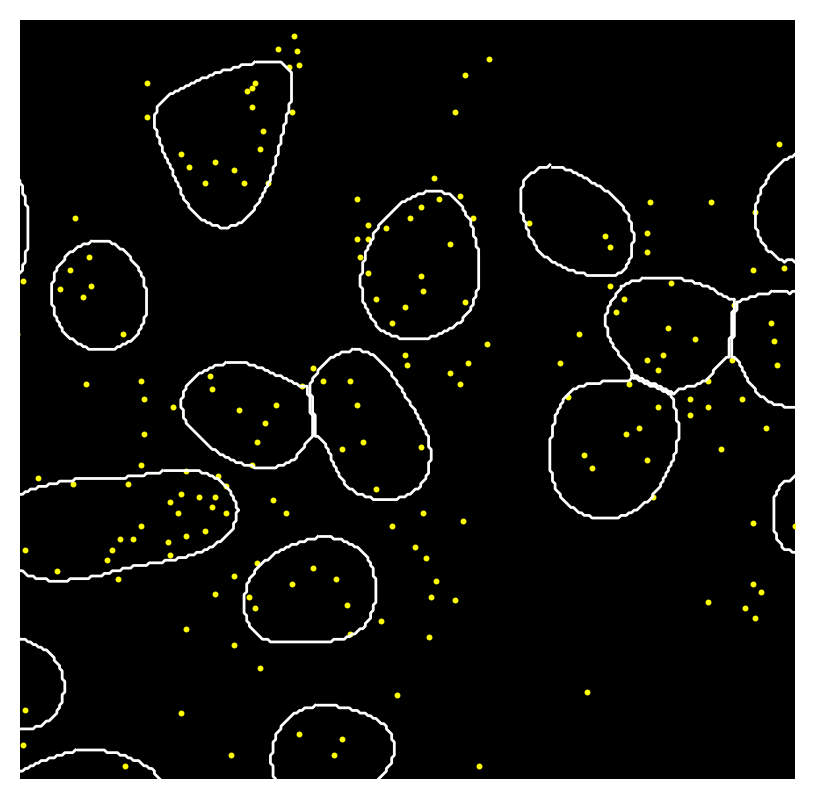

In [30]:
# convert the mask to a contour
bmask_contour = utils.outlines_list(nmasks)

# plot the contour of cmask and bmask on the same image
plt.figure(figsize=(5, 5), dpi=200)
psudo_img = np.zeros_like(img_555)
plt.imshow(psudo_img, cmap='gray', clim=(0, 1))
# plt.imshow(img_555, cmap=cc.cm.fire, clim=(500, 2000))
# add contour of cmask
lw=1
# add contour of bmask
for contour in bmask_contour:
    plt.plot(contour[:, 0], contour[:, 1], color='white', linewidth=lw)
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=5, marker = '.')
# set black background
plt.axis('off')
plt.xlim(308, 308+98*3)
plt.ylim(132+98*3, 138)
plt.show()


## Cellular and nuclear segmentation

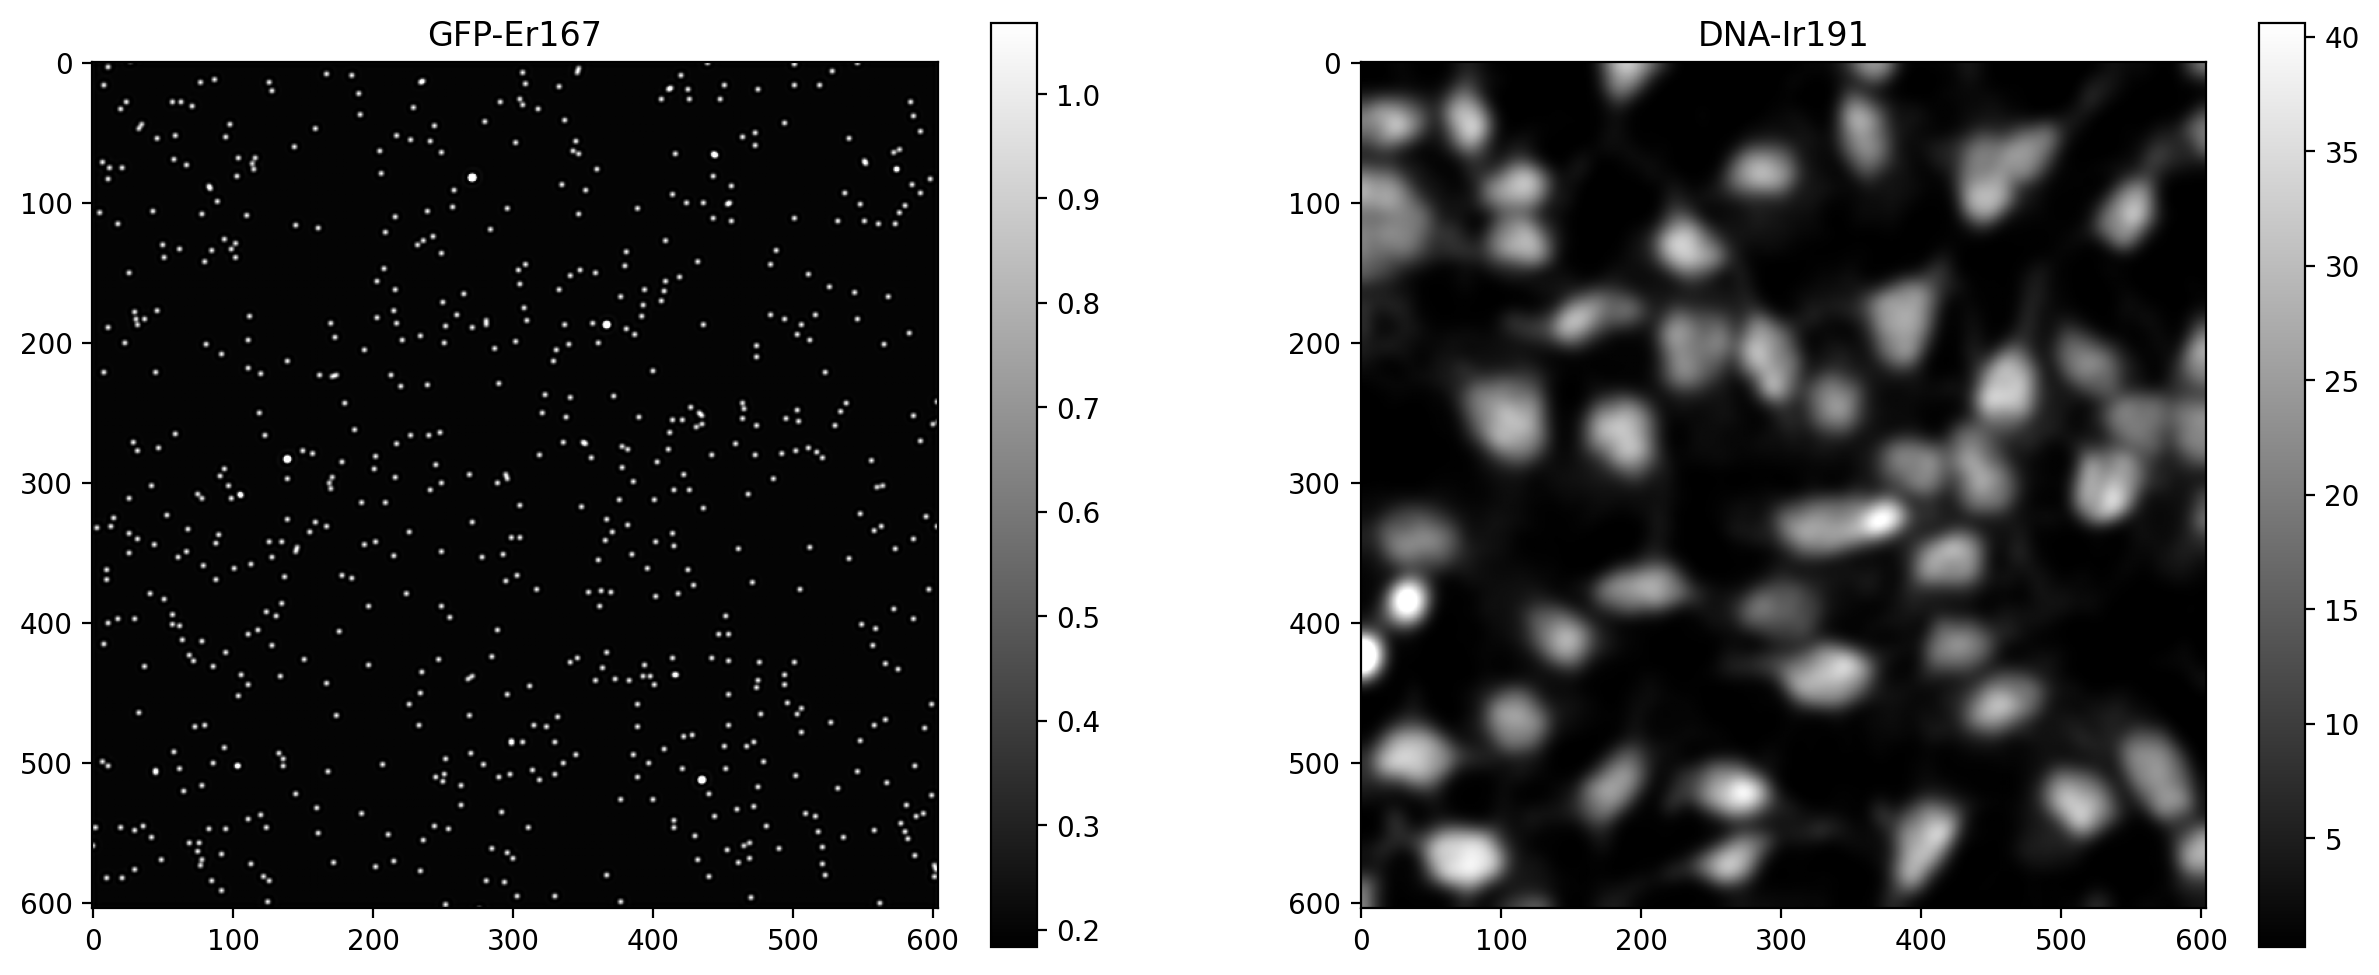

In [25]:
img_nuc = img[11,:,:]
img_cyto = img[8,:,:]

# blur the img_nuc
img_nuc = cv2.GaussianBlur(img_nuc, (0, 0), 6)
img_cyto = cv2.GaussianBlur(img_cyto, (0, 0), 1)

plt.figure(figsize=(15, 6), dpi = 200)
plt.subplot(121)
plt.imshow(img_cyto, cmap='gray')
plt.clim(np.percentile(img_cyto, 5), np.percentile(img_cyto, 99.9))
plt.title("GFP-Er167")
plt.colorbar()

plt.subplot(122)
plt.imshow(img_nuc, cmap='gray')
plt.clim(np.percentile(img_nuc, 5), np.percentile(img_nuc, 99.9))
plt.title("DNA-Ir191")
plt.colorbar()
plt.show()


In [26]:
model_cyto = models.Cellpose(model_type="cyto3")
model_nuc = models.Cellpose(model_type="nuclei")

In [27]:
channels = [[0, 0]]

cmasks, cflows, cstyles, cdiams = model_cyto.eval(img_cyto, diameter=None, channels = channels)
nmasks, nflows, nstyles, ndiams = model_nuc.eval(img_nuc, diameter=None, channels = channels)

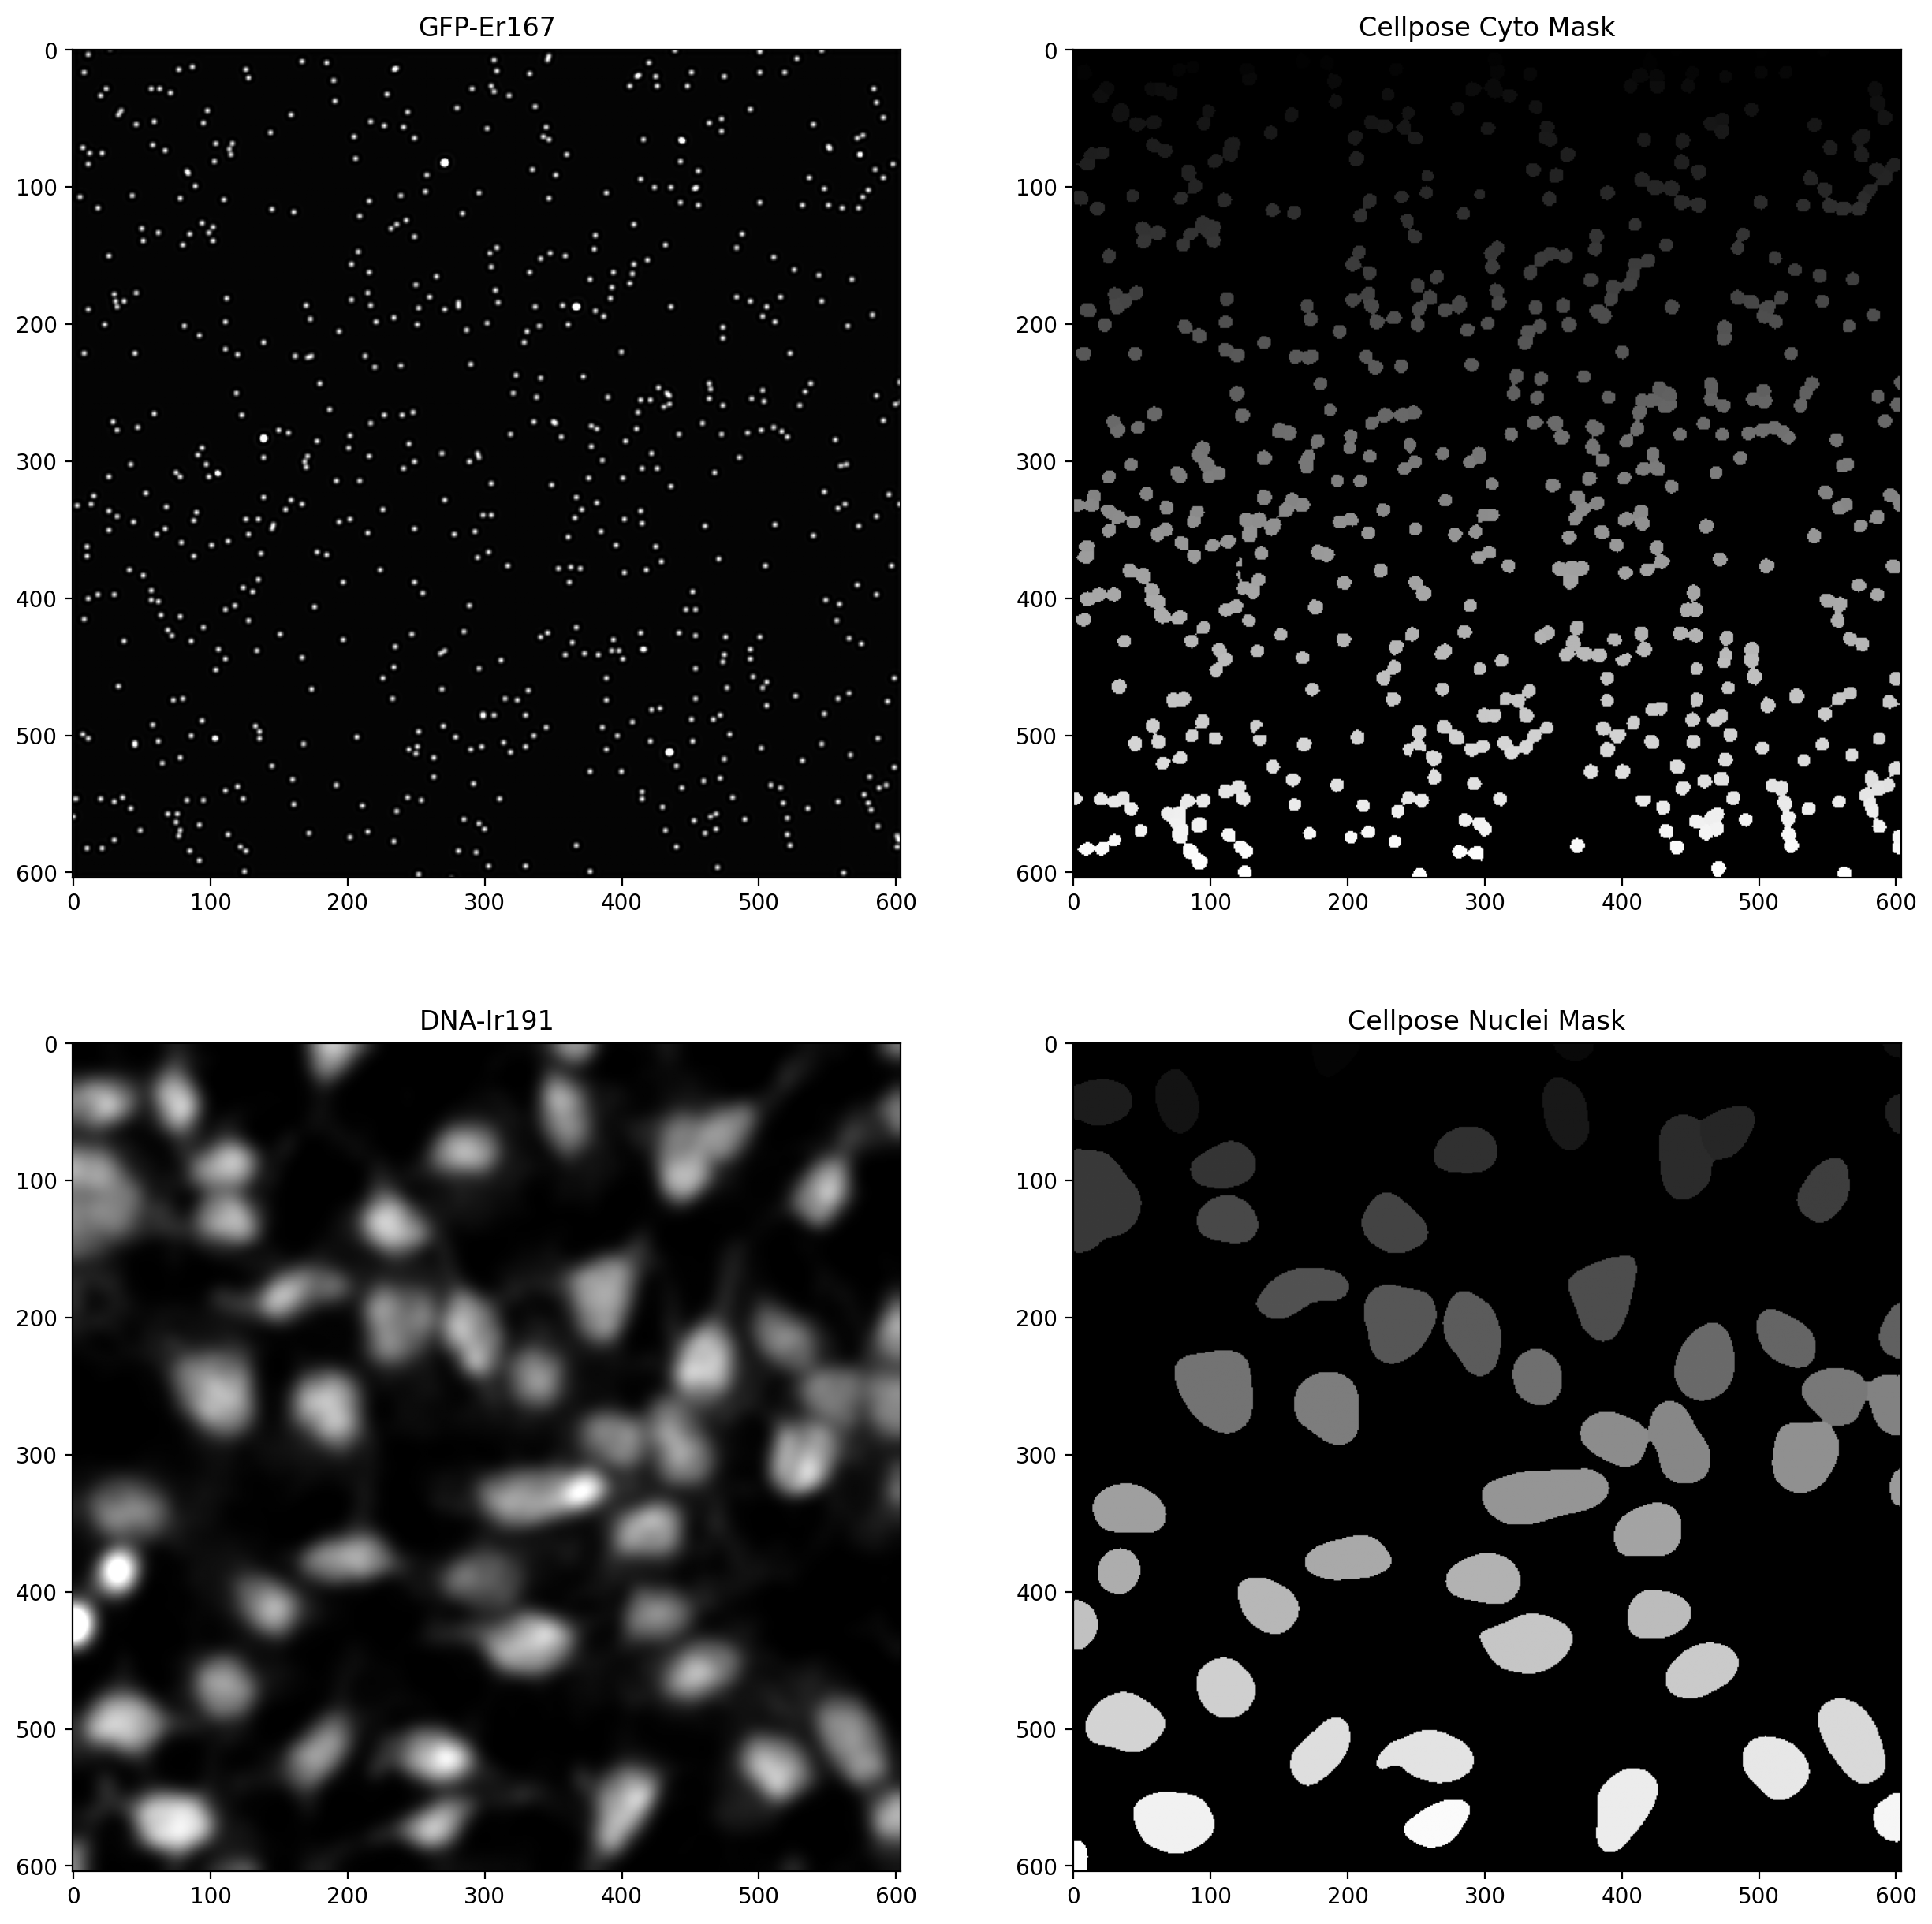

In [28]:
# show the masks
plt.figure(figsize=(15, 15), dpi = 200)
plt.subplot(221)
plt.imshow(img_cyto, cmap='gray')
plt.clim(np.percentile(img_cyto, 5), np.percentile(img_cyto, 99.9))
plt.title("GFP-Er167")

plt.subplot(222)
plt.imshow(cmasks, cmap='gray')
plt.title("Cellpose Cyto Mask")

plt.subplot(223)
plt.imshow(img_nuc, cmap='gray')
plt.clim(np.percentile(img_nuc, 5), np.percentile(img_nuc, 99.9))
plt.title("DNA-Ir191")

plt.subplot(224)
plt.imshow(nmasks, cmap='gray')
plt.title("Cellpose Nuclei Mask")
plt.show()

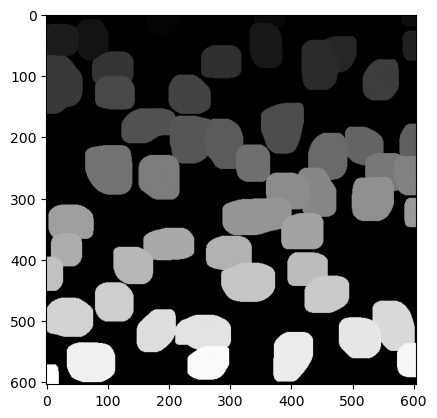

In [30]:
# Optionally dilate the nuclear mask to simulate the cytoplasm
kernel = np.ones((5,5),np.uint8)
cmasks = cv2.dilate(nmasks.astype(np.uint8), kernel, iterations=5)

plt.imshow(cmasks, cmap='gray')



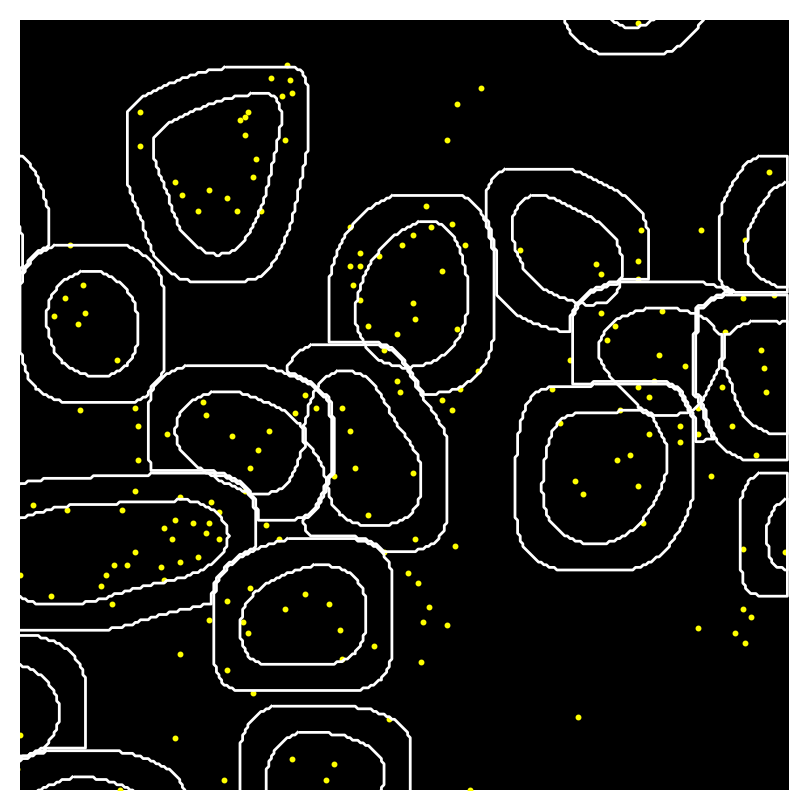

In [39]:
# convert the mask to a contour
cmask_contour = utils.outlines_list(cmasks)
bmask_contour = utils.outlines_list(nmasks)

# plot the contour of cmask and bmask on the same image
plt.figure(figsize=(5, 5), dpi=200)
psudo_img = np.zeros_like(img_555)
plt.imshow(psudo_img, cmap='gray', clim=(0, 1))
# plt.imshow(img_555, cmap=cc.cm.fire, clim=(500, 2000))
# add contour of cmask
lw=1
for contour in cmask_contour:
    plt.plot(contour[:, 0], contour[:, 1], color='white', linewidth=lw)
# add contour of bmask
for contour in bmask_contour:
    plt.plot(contour[:, 0], contour[:, 1], color='white', linewidth=lw)
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=5, marker = '.')
# set black background
plt.axis('off')
plt.xlim(310, 310+98*3)
plt.ylim(127+98*3, 127)

plt.show()


In [33]:
# generate a df for the cellpose mask
cyto_df = skimage.measure.regionprops_table(cmasks, img_488, properties=['label', 'centroid', 'area', 'mean_intensity'])
cyto_df = pd.DataFrame(cyto_df)

cyto_df['total_intensity'] = cyto_df['area'] * cyto_df['mean_intensity']

# change the column name "centroid-0" to "y"
cyto_df.rename(columns={'centroid-0': 'y'}, inplace=True)
# change the column name "centroid-1" to "x"
cyto_df.rename(columns={'centroid-1': 'x'}, inplace=True)

cyto_df

label           y           x    area  mean_intensity  total_intensity
0       1   15.325194  189.438356  1679.0        1.465192      2460.057708
1       2    8.127533  366.061979   839.0        1.983218      1663.920153
2       3    9.384615  592.155983   468.0        2.425279      1135.030620
3       4   40.687456   75.373519  2870.0        2.492509      7153.500209
4       5   50.950652  358.389393  3526.0        2.371019      8360.212329
5       6   41.668707   25.112471  2614.0        2.912149      7612.358404
6       7   50.830357  593.085317  1008.0        2.597282      2618.060025
7       8   60.040209  486.337859  1915.0        2.625780      5028.367794
8       9   83.029228  445.026212  4311.0        3.138680     13530.851000
9      10   77.876792  285.705703  3279.0        2.423133      7945.454305
10     11   83.733665  109.032480  2617.0        3.978024     10410.489722
11     12  114.024806   25.709901  4757.0        2.542623     12095.255268
12     13  107.234882  546.891031  3423.0        3.550131     12152.097715
13     14  131.575462  233.181794  3790.0        2.670062     10119.533168
14     15  128.411200  112.117574  3232.0        2.977956      9624.753749
15     16  184.012303  386.158294  4877.0        3.369026     16430.738857
16     17  180.797068  163.327521  3957.0        2.282510      9031.892015
17     18  203.177454  232.071076  4249.0        2.092222      8889.852781
18     19  209.200244  288.737241  4095.0        2.533295     10373.843358
19     20  206.681924  591.042669  1289.0        1.940025      2500.691838
20     21  211.463289  516.615305  2901.0        1.910260      5541.665076
21     22  228.981761  462.196978  3838.0        3.396123     13034.319726
22     23  242.977148  337.678146  3107.0        1.975092      6136.610568
23     24  252.254788  103.755791  5483.0        2.426620     13305.155545
24     25  248.174132  547.656769  1987.0        2.644568      5254.755878
25     26  265.307149  185.336976  4392.0        3.047794     13385.910896
26     27  262.107914  586.920384  2085.0        3.033524      6324.896943
27     28  291.064771  446.597597  3412.0        2.533607      8644.666939
28     29  284.805296  396.023364  3210.0        2.401426      7708.576410
29     30  300.670615  532.702346  4475.0        2.320507     10384.268550
30     31  328.807386  341.398405  5768.0        3.771908     21756.362771
31     32  323.665891  594.459837   859.0        2.538222      2180.332749
32     33  337.259108   40.805305  3431.0        2.425189      8320.823233
33     34  355.052688  418.711153  3739.0        2.835363     10601.423293
34     35  374.979051  201.428534  3771.0        2.672006     10076.134027
35     36  382.942067   34.313446  2313.0        3.844285      8891.832096
36     37  388.116393  297.159320  3471.0        2.040775      7083.529019
37     38  409.532152  141.651901  3499.0        2.132175      7460.481326
38     39  414.064345  423.860697  3015.0        1.810858      5459.737755
39     40  423.612117   12.552228  1436.0        3.339431      4795.422236
40     41  437.280724  330.439592  4809.0        2.900286     13947.473671
41     42  457.067131  457.621740  3873.0        2.524630      9777.891206
42     43  469.772437  110.687691  3599.0        2.280369      8207.048999
43     44  495.186220   37.579842  4296.0        2.458426     10561.399954
44     45  505.506588  567.655294  4250.0        3.566021     15155.587379
45     46  516.498368  179.800598  3676.0        2.141184      7870.991257
46     47  518.294132  256.731425  4226.0        2.439351     10308.695241
47     48  527.647338  511.688578  4001.0        2.578731     10317.504144
48     49  557.349732  401.337657  4472.0        2.151779      9622.753943
49     50  567.416885   72.812773  4572.0        3.104201     14192.406224
50     51  564.617237  589.110266  1578.0        3.505104      5531.054073
51     52  568.746737  265.043505  3218.0        2.790263      8979.065307
52     53  587.918462    9.69

## Cell-dependent amplicon analysis

In [34]:
# for each mask (with label) in the cellpose mask, find the corresponding RCA mask, add the "amplicon_count" column to the cyto_df, add the "cyto_label" column to the amp_df
cyto_df['amplicon_count'] = 0
amp_df['cyto_label'] = 0

for i in range(len(cyto_df)):
    # get the label of the cellpose mask
    label = cyto_df['label'][i]
    amp_count = 0
    for j in range(len(amp_df)):
        amp_x = amp_df['x'][j].astype(int)
        amp_y = amp_df['y'][j].astype(int)
        amp_label = cmasks[amp_y, amp_x]
        if amp_label == label:
            amp_count += 1
            amp_df.loc[j, 'cyto_label'] = label
    cyto_df.loc[i, 'amplicon_count'] = amp_count
cyto_df['amplicon_count'] = cyto_df['amplicon_count'].astype(int)
amp_df['cyto_label'] = amp_df['cyto_label'].astype(int)

In [35]:
cyto_df

label           y           x    area  mean_intensity  total_intensity  \
0       1   15.325194  189.438356  1679.0        1.465192      2460.057708   
1       2    8.127533  366.061979   839.0        1.983218      1663.920153   
2       3    9.384615  592.155983   468.0        2.425279      1135.030620   
3       4   40.687456   75.373519  2870.0        2.492509      7153.500209   
4       5   50.950652  358.389393  3526.0        2.371019      8360.212329   
5       6   41.668707   25.112471  2614.0        2.912149      7612.358404   
6       7   50.830357  593.085317  1008.0        2.597282      2618.060025   
7       8   60.040209  486.337859  1915.0        2.625780      5028.367794   
8       9   83.029228  445.026212  4311.0        3.138680     13530.851000   
9      10   77.876792  285.705703  3279.0        2.423133      7945.454305   
10     11   83.733665  109.032480  2617.0        3.978024     10410.489722   
11     12  114.024806   25.709901  4757.0        2.542623     12095.255268   
12     13  107.234882  546.891031  3423.0        3.550131     12152.097715   
13     14  131.575462  233.181794  3790.0        2.670062     10119.533168   
14     15  128.411200  112.117574  3232.0        2.977956      9624.753749   
15     16  184.012303  386.158294  4877.0        3.369026     16430.738857   
16     17  180.797068  163.327521  3957.0        2.282510      9031.892015   
17     18  203.177454  232.071076  4249.0        2.092222      8889.852781   
18     19  209.200244  288.737241  4095.0        2.533295     10373.843358   
19     20  206.681924  591.042669  1289.0        1.940025      2500.691838   
20     21  211.463289  516.615305  2901.0        1.910260      5541.665076   
21     22  228.981761  462.196978  3838.0        3.396123     13034.319726   
22     23  242.977148  337.678146  3107.0        1.975092      6136.610568   
23     24  252.254788  103.755791  5483.0        2.426620     13305.155545   
24     25  248.174132  547.656769  1987.0        2.644568      5254.755878   
25     26  265.307149  185.336976  4392.0        3.047794     13385.910896   
26     27  262.107914  586.920384  2085.0        3.033524      6324.896943   
27     28  291.064771  446.597597  3412.0        2.533607      8644.666939   
28     29  284.805296  396.023364  3210.0        2.401426      7708.576410   
29     30  300.670615  532.702346  4475.0        2.320507     10384.268550   
30     31  328.807386  341.398405  5768.0        3.771908     21756.362771   
31     32  323.665891  594.459837   859.0        2.538222      2180.332749   
32     33  337.259108   40.805305  3431.0        2.425189      8320.823233   
33     34  355.052688  418.711153  3739.0        2.835363     10601.423293   
34     35  374.979051  201.428534  3771.0        2.672006     10076.134027   
35     36  382.942067   34.313446  2313.0        3.844285      8891.832096   
36     37  388.116393  297.159320  3471.0        2.040775      7083.529019   
37     38  409.532152  141.651901  3499.0        2.132175      7460.481326   
38     39  414.064345  423.860697  3015.0        1.810858      5459.737755   
39     40  423.612117   12.552228  1436.0        3.339431      4795.422236   
40     41  437.280724  330.439592  4809.0        2.900286     13947.473671   
41     42  457.067131  457.621740  3873.0        2.524630      9777.891206   
42     43  469.772437  110.687691  3599.0        2.280369      8207.048999   
43     44  495.186220   37.579842  4296.0        2.458426     10561.399954   
44     45  505.506588  567.655294  4250.0        3.566021     15155.587379   
45     46  516.498368  179.800598  3676.0        2.141184      7870.991257   
46     47  518.294132  256.731425  4226.0        2.439351     10308.695241   
47     48  527.647338  511.688578  4001.0        2.578731     10317.504144   
48     49  557.349732  401.337657  4472.0        2.151779      9622.753943   
49     50  567.416885   72.812773  4572.0        3.104201     14192.406224   
50     51  564.617237  589

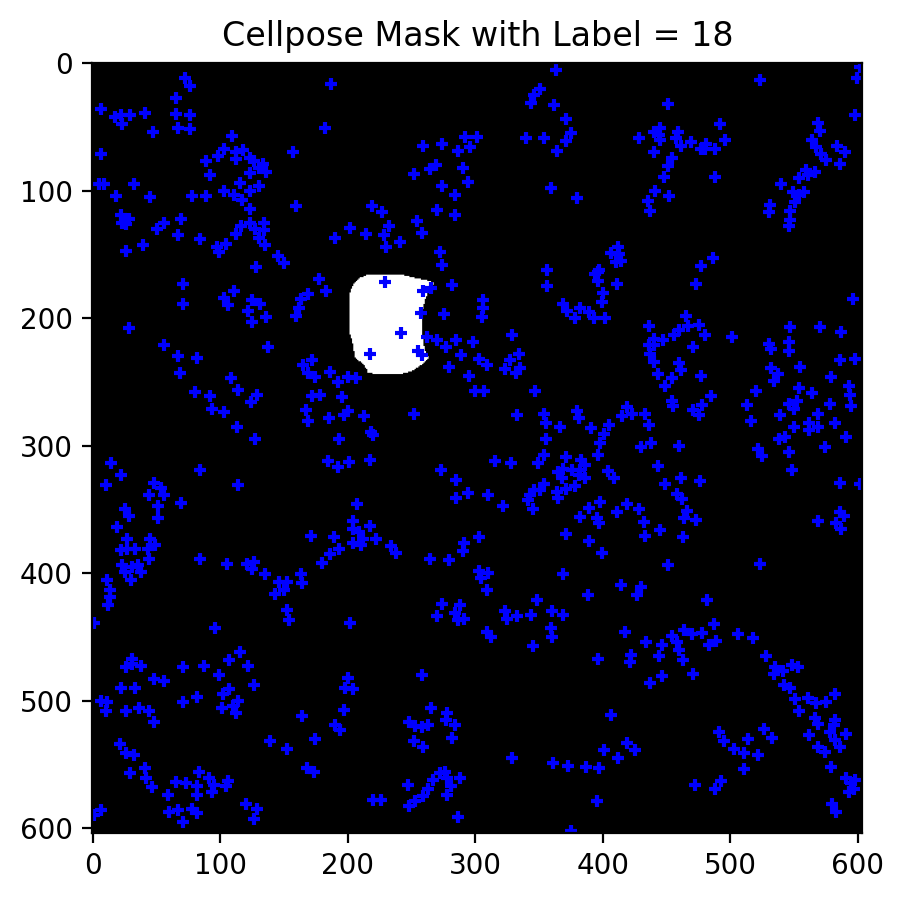

In [36]:
# show mask with label = 18
plt.figure(figsize=(5, 5), dpi=200)
plt.imshow(cmasks == 18, cmap='gray')
plt.title('Cellpose Mask with Label = 18')
plt.clim(0, 1)

for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='blue', s=20, marker = '+')

plt.show()

In [37]:
# compute the proportion of amplicons with label = 0 and > 0
total_amplicons = len(amp_df)
cyto_amplicons  = cyto_df['amplicon_count'].sum()

proportion_cyto = cyto_amplicons / total_amplicons

print(f"Amplicons within cytoplasm: {cyto_amplicons} / {total_amplicons} = {proportion_cyto:.2f}")


Amplicons within cytoplasm: 671 / 844 = 0.80


Boxplot of how amplicon count distribution looks like

Median amplicon count: 13.0
Mean amplicon count: 12.660377358490566


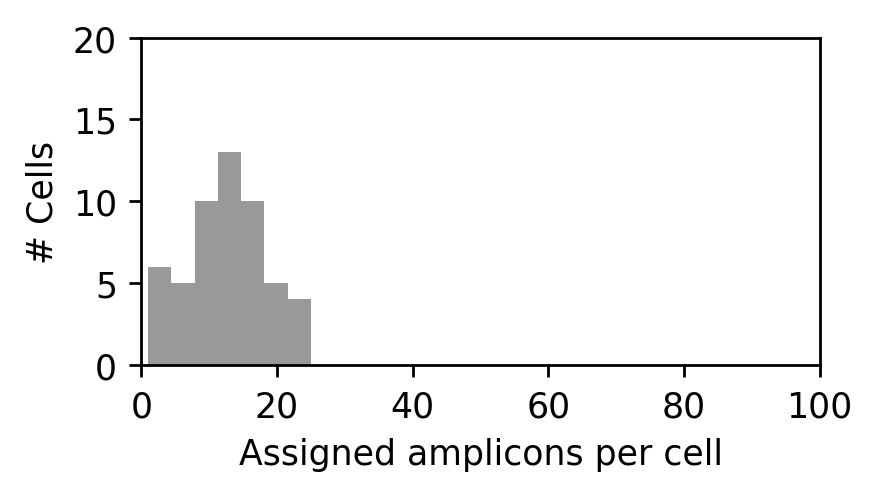

Median diameter: 1442.1639283815446
Mean diameter: 1502.9864512129493


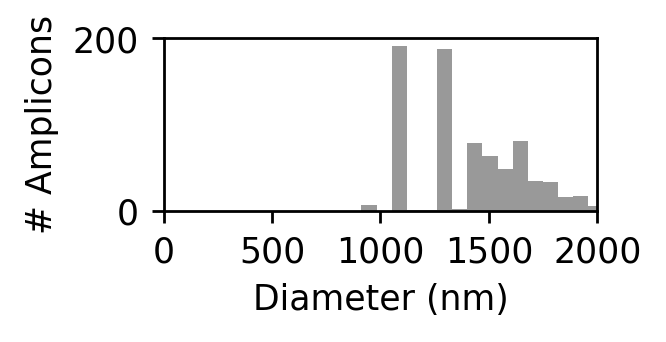

In [38]:
# plot a histogram of the amplicon count for each cellpose label
# print median and mean of the amplicon count
print(f"Median amplicon count: {cyto_df['amplicon_count'].median()}")
print(f"Mean amplicon count: {cyto_df['amplicon_count'].mean()}")

plt.figure(figsize=(3.5,1.7), dpi=250)
# plt.subplot(121)
plt.hist(cyto_df['amplicon_count'], bins='auto', color='gray', alpha=0.8, label='Amplicon Count per Cell', density=False)
# plt.title('Amplicon Count per Cell')
plt.xlim(0, 100)
plt.ylim(0, 20)
plt.xlabel('Assigned amplicons per cell')
plt.ylabel('# Cells')

plt.show()


plt.figure(figsize=(3.3,2), dpi=250)
# plt.subplot(122)
voxel_size = 0.33
diameter = np.sqrt(amp_df['area']/np.pi) * 2 * voxel_size * 1000
# print the median and mean of diameter
print(f"Median diameter: {diameter.median()}")
print(f"Mean diameter: {diameter.mean()}")
plt.hist(diameter, bins='auto', color='gray', alpha=0.8, label='Amplicon diameter', density=False)
plt.xlim(0, 2000)
# plt.ylim(0, 150)
# plt.title('Amplicon Diameter')

plt.xlabel('Diameter (nm)')
plt.ylabel('# Amplicons')

# set subplot distance
plt.tight_layout(pad=3.0)
plt.show()


Compute the pair-wise distance of amplicons

In [40]:
voxel_size = 0.33

def get_amplicon_distance(x1, y1, x2, y2, voxel_size):
    # calculate the distance between two points
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2) * voxel_size * 1000

# compute pairwise distance between all amplicons and plot a histogram
def compute_pairwise_distance(df, voxel_size):
    distances = []
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            if df['cyto_label'][i] == df['cyto_label'][j]:
                # only compute distance for amplicons with the same cell label
                # skip if the amplicon is not in the cell
                if df['cyto_label'][i] == 0 or df['cyto_label'][j] == 0:
                    continue
                x1, y1 = df['x'][i], df['y'][i]
                x2, y2 = df['x'][j], df['y'][j]
                distance = get_amplicon_distance(x1, y1, x2, y2, voxel_size)
                distances.append(distance)
    return distances

# compute pairwise distance for all amplicons
distances = compute_pairwise_distance(amp_df, voxel_size)


Median pairwise distance: 9366.404059189415
Mean pairwise distance: 9892.68301664418
1409.7606179773925


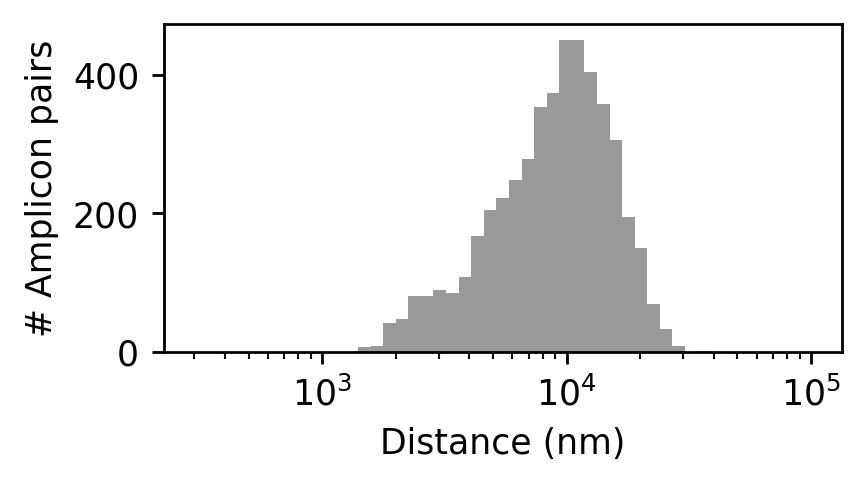

In [42]:
# print the median and mean of the pairwise distance
print(f"Median pairwise distance: {np.median(distances)}")
print(f"Mean pairwise distance: {np.mean(distances)}")
print(np.min(distances))

plt.figure(figsize=(3.5,1.7), dpi=250)
# plot a histogram of the pairwise distance, use binning that match the log10 scale
plt.hist(distances, bins=np.logspace(np.log10(300), np.log10(100000), 50), color='gray', alpha=0.8, label='Pairwise distance', density=False)
plt.xlabel('Distance (nm)')
plt.ylabel('# Amplicon pairs')
plt.xscale('log')
plt.show()

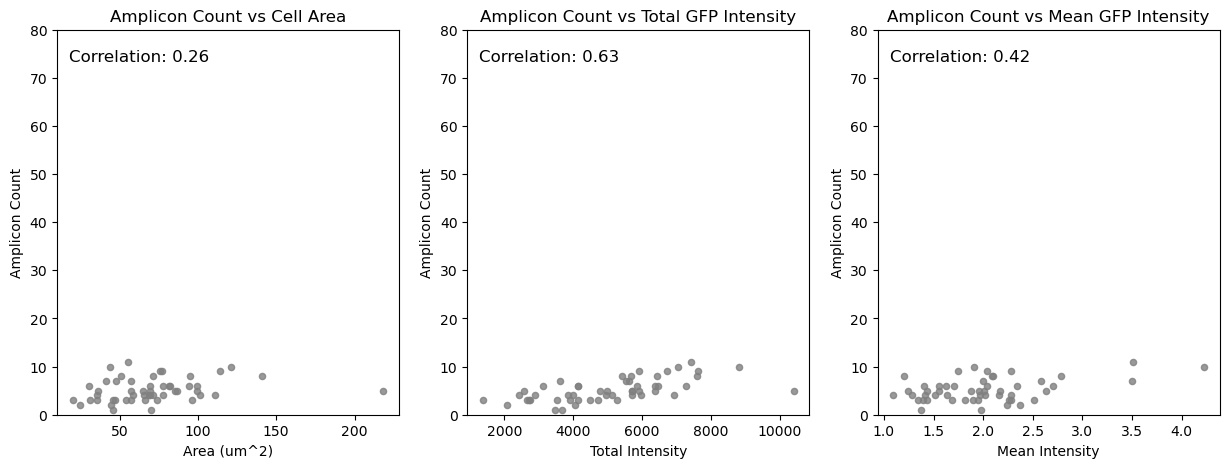

In [39]:
# remove those with amplicon count = 0
cyto_df_filtered = cyto_df[cyto_df['amplicon_count'] > 0]

# plot a scatter plot of amplicon count vs area
plt.figure(figsize=(15, 5), dpi=100)
plt.subplot(131)
plt.scatter(cyto_df_filtered['area'] * voxel_size**2, cyto_df_filtered['amplicon_count'], c='gray', alpha=0.8, s=20)
# add correlation value
corr = np.corrcoef(cyto_df_filtered['area'] * voxel_size**2, cyto_df_filtered['amplicon_count'])[0, 1]
plt.text(0.24, 0.93, f'Correlation: {corr:.2f}', fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.ylim(0, 80)
plt.title('Amplicon Count vs Cell Area')
plt.xlabel('Area (um^2)')
plt.ylabel('Amplicon Count')

plt.subplot(132)
plt.scatter(cyto_df_filtered['total_intensity'], cyto_df_filtered['amplicon_count'], c='gray', alpha=0.8, s=20)
# add correlation value
corr = np.corrcoef(cyto_df_filtered['total_intensity'], cyto_df_filtered['amplicon_count'])[0, 1]
plt.text(0.24, 0.93, f'Correlation: {corr:.2f}', fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.ylim(0, 80)
plt.title('Amplicon Count vs Total GFP Intensity')
plt.xlabel('Total Intensity')
plt.ylabel('Amplicon Count')

# plot a scatter plot of amplicon count vs mean intensity
plt.subplot(133)
plt.scatter(cyto_df_filtered['mean_intensity'], cyto_df_filtered['amplicon_count'], c='gray', alpha=0.8, s=20)
# add correlation value
corr = np.corrcoef(cyto_df_filtered['mean_intensity'], cyto_df_filtered['amplicon_count'])[0, 1]
plt.text(0.24, 0.93, f'Correlation: {corr:.2f}', fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.ylim(0, 80)
plt.title('Amplicon Count vs Mean GFP Intensity')
plt.xlabel('Mean Intensity')
plt.ylabel('Amplicon Count')
plt.show()

###  Intensity ratio distribution per cell

Filter the amplicons of which the cell have less than 10 replicates

In [45]:
amp_count_thres = 10
cyto_df_filtered = cyto_df[cyto_df['amplicon_count'] > 0]
label_to_remove = cyto_df_filtered[cyto_df_filtered['amplicon_count'] < amp_count_thres]['label'].values
cyto_df_filtered = cyto_df_filtered[~cyto_df_filtered['label'].isin(label_to_remove)]
amp_df = amp_df[~amp_df['cyto_label'].isin(label_to_remove)]

/tmp/ipykernel_447629/1329503992.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(amp_df_cell['total_intensity_488'], amp_df_cell['total_intensity_555'], s=40, alpha=0.5, marker='.', edgecolors='none', c=cmap(cell))


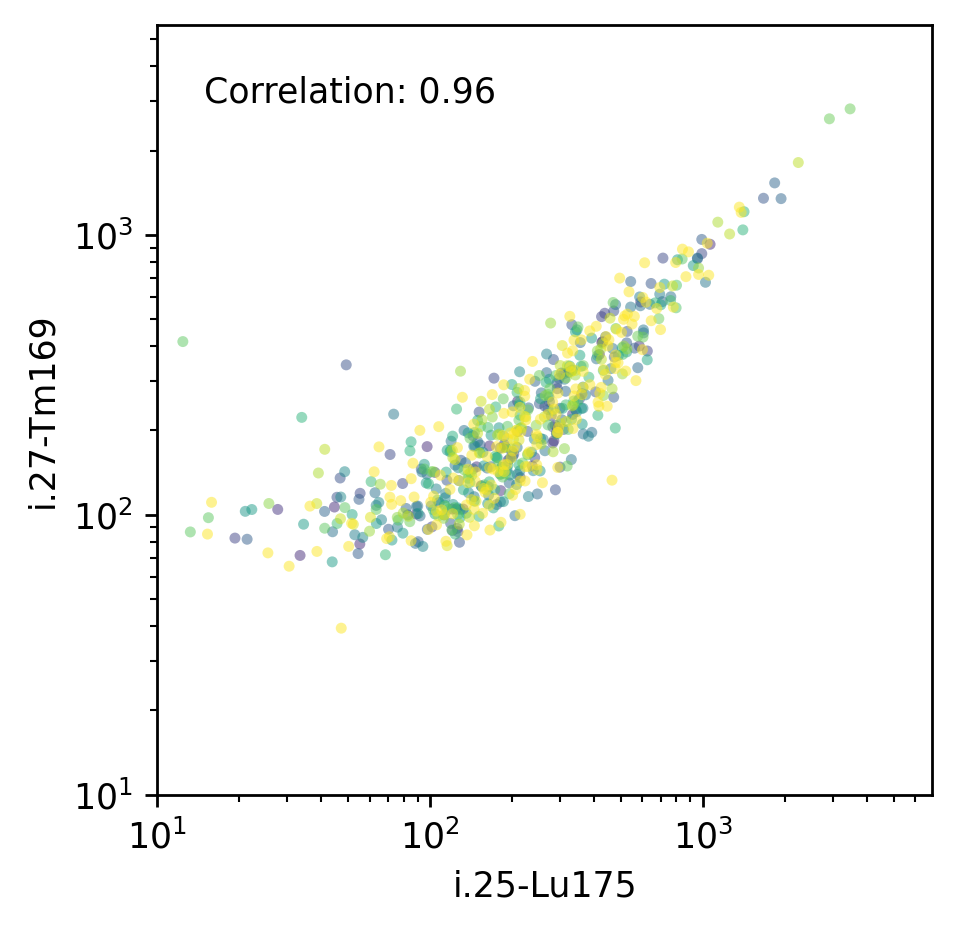

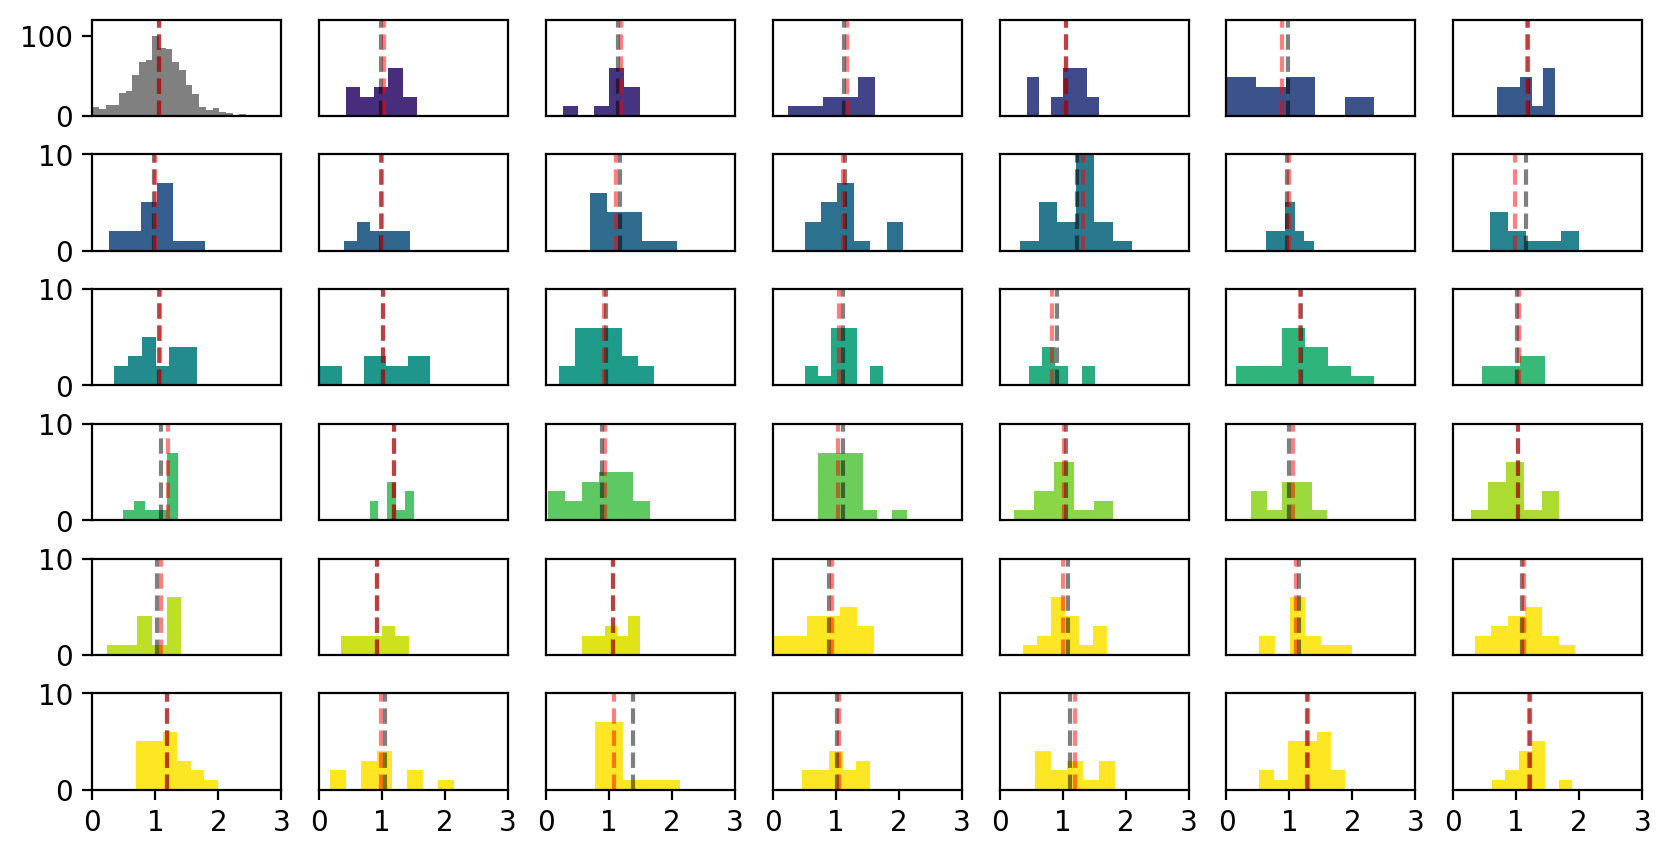

In [72]:
# for each cellpose label, compute the intensity ratio of the amplicon count, plot a histogram
cyto_label_list = cyto_df_filtered['label'].unique()
# define a color map for the number of cellpose labels
cmap = plt.get_cmap('viridis', len(cyto_label_list))
# plot scatter plot of total intensity
plt.figure(figsize=(4,4), dpi = 250)
for cell in cyto_label_list:
    amp_df_cell = amp_df[amp_df['cyto_label'] == cell]
    plt.scatter(amp_df_cell['total_intensity_488'], amp_df_cell['total_intensity_555'], s=40, alpha=0.5, marker='.', edgecolors='none', c=cmap(cell))
    
correlation = np.corrcoef(amp_df['total_intensity_488'], amp_df['total_intensity_555'])[0, 1]
plt.text(0.06, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=10)

plt.xlabel('i.25-Lu175')
plt.ylabel('i.27-Tm169')
# plt.title('Amplicon total intensity')

plt.xlim(10, 2*np.max(amp_df['total_intensity_488']))
plt.ylim(10, 2*np.max(amp_df['total_intensity_555']))
# turn on log scale
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.figure(figsize=(10,5), dpi = 200)
# further divide this into more subplo
plt.subplot(len(cyto_label_list+1)//7+1, 7, 1)
plt.hist(amp_df['total_intensity_488']/amp_df['total_intensity_555'], bins='auto', density=False, alpha=1, color='gray')
# add mean and median
mean_ratio = np.mean(amp_df['total_intensity_488']/amp_df['total_intensity_555'])
median_ratio = np.median(amp_df['total_intensity_488']/amp_df['total_intensity_555'])
plt.axvline(mean_ratio, color='black', linestyle='--', label='Mean: {:.2f}'.format(mean_ratio), alpha=0.5)
plt.axvline(median_ratio, color='red', linestyle='--', label='Median: {:.2f}'.format(median_ratio), alpha=0.5)
plt.xlim(0, 3)
plt.ylim(0, 120)
plt.xticks([])
# plt.title('All Cells')

count = 2
for cell in cyto_label_list:
    amp_df_cell = amp_df[amp_df['cyto_label'] == cell]
    # plot a smoothened histogram of the intensity ratio
    plt.subplot(len(cyto_label_list+1)//7+1, 7, count)
    plt.hist(amp_df_cell['total_intensity_488']/amp_df_cell['total_intensity_555'], bins='auto', density=False, alpha=1, color=cmap(cell))
    # add mean and median
    mean_ratio = np.mean(amp_df_cell['total_intensity_488']/amp_df_cell['total_intensity_555'])
    median_ratio = np.median(amp_df_cell['total_intensity_488']/amp_df_cell['total_intensity_555'])
    plt.axvline(mean_ratio, color='black', linestyle='--', label='Mean: {:.2f}'.format(mean_ratio), alpha=0.5)
    plt.axvline(median_ratio, color='red', linestyle='--', label='Median: {:.2f}'.format(median_ratio), alpha=0.5)
    plt.xlim(0, 3)
    plt.ylim(0, 10)
    # show ticks only on the very left or very bottom
    # show x ticks only on the bottom
    if count <= len(cyto_label_list+1)-6:
        plt.xticks([])
    else:
        plt.xticks([0, 1, 2, 3])
    if count % 7 != 1:
        plt.yticks([])
    # plt.title('CID: {}'.format(cell))
    count += 1
# set the space between subplots
plt.subplots_adjust(hspace=0.4)
# plt.xlabel('Intensity Ratio (Lu175 / Tm169)')
# plt.ylabel('Density')
# plt.title('Intensity Ratio Distribution')
# add overall x and y labels
plt.show()
